## Data preparation

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import pickle
import torch
import torch.nn.functional as F
import tqdm
from torch import Tensor
from torch.nn import LSTM
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GATConv, SAGEConv, to_hetero
import torch_geometric.transforms as T
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import Counter

import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

pd.set_option('display.max_rows', None)

In [3]:
with open('data10000.pkl', 'rb') as file:
    data = pickle.load(file)

In [4]:
print(data)

HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={ edge_index=[2, 10000] },
  (product, rev_reviews, reviewer)={ edge_index=[2, 10000] }
)


Split data into training, test and val sets

In [5]:
# Define your parameters in a dictionary
transform_parameters = {
    "num_val":0.1,
    "num_test":0.2,
    "is_undirected":False,
    "disjoint_train_ratio":0.3,
    "neg_sampling_ratio":1.0,
    "add_negative_train_samples":True,
    "edge_types":("reviewer", "reviews", "product"),
    "rev_edge_types":("product", "rev_reviews", "reviewer"), 
}

# Create the RandomLinkSplit transform object using the parameters
transform = T.RandomLinkSplit(
    **transform_parameters  # This unpacks the dictionary into the function arguments
)
train_data, val_data, test_data = transform(data)



In [6]:
print("Train data")
print(train_data)
print("__________________________________________\n")
print("Validation data")
print(val_data)
print("__________________________________________\n")
print("Test data")
print(test_data)

Train data
HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 4900],
    edge_label=[4200],
    edge_label_index=[2, 4200],
  },
  (product, rev_reviews, reviewer)={ edge_index=[2, 4900] }
)
__________________________________________

Validation data
HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 7000],
    edge_label=[2000],
    edge_label_index=[2, 2000],
  },
  (product, rev_reviews, reviewer)={ edge_index=[2, 7000] }
)
__________________________________________

Test data
HeteroData(
  reviewer={
    node_id=[9085],
    x=[10000, 305],
  },
  product={
    node_id=[63],
    x=[63, 402],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 8000],
    edge_label=[4000],
    edge_label_index=[2, 4000],
  },
  (product, rev_reviews, rev

In [7]:
with open('train_data10000.pkl', 'wb') as file:
    pickle.dump(train_data, file)
with open('test_data10000.pkl', 'wb') as file:
    pickle.dump(test_data, file)
with open('val_data10000.pkl', 'wb') as file:
    pickle.dump(val_data, file)

In [7]:
with open('train_data10000.pkl', 'rb') as file:
    train_data = pickle.load(file)
with open('test_data10000.pkl', 'rb') as file:
    test_data = pickle.load(file)
with open('val_data10000.pkl', 'rb') as file:
    val_data = pickle.load(file)

In [8]:
# Configuration for loaders
# Train loader configuration with 20 neighbors in the first hop and 10 in the second
loader_configs = {
    "Train_Loader_Config": {
        "num_neighbors": [-1, -1],  # Number of neighbors for sampling at each hop
        "batch_size": 512,          # Batch size for training
        "shuffle": True             # Shuffle the data during training
    }
}

# Define the test loader configuration
# Similar configuration as train loader but used for testing
test_loader_config = {
    "num_neighbors": [-1, -1],   # Number of neighbors for sampling at each hop
    "batch_size": 512,           # Batch size for testing
    "shuffle": True              # Shuffle the data during testing
}
loader_configs["Test_Loader_Config"] = test_loader_config

# Validation loader configuration
val_loader_config = {
    "num_neighbors": [-1, -1],   # Number of neighbors for sampling at each hop
    "batch_size": 99999,         # Large batch size for validation
    "shuffle": False              # Shuffle the data during validation
}
loader_configs["Val_Loader_Config"] = val_loader_config

# Define seed edges for training
edge_label_index = train_data["reviewer", "reviews", "product"].edge_label_index
edge_label = train_data["reviewer", "reviews", "product"].edge_label

# Initialize the training data loader
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=loader_configs["Train_Loader_Config"]["num_neighbors"],
    edge_label_index=(("reviewer", "reviews", "product"), edge_label_index),
    edge_label=edge_label,
    batch_size=loader_configs["Train_Loader_Config"]["batch_size"],
    shuffle=loader_configs["Train_Loader_Config"]["shuffle"],
)

# Define seed edges for testing
edge_label_index_test = test_data["reviewer", "reviews", "product"].edge_label_index
edge_label_test = test_data["reviewer", "reviews", "product"].edge_label

# Initialize the test data loader
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=loader_configs["Test_Loader_Config"]["num_neighbors"],
    edge_label_index=(("reviewer", "reviews", "product"), edge_label_index_test),
    edge_label=edge_label_test,
    batch_size=loader_configs["Test_Loader_Config"]["batch_size"],
    shuffle=loader_configs["Test_Loader_Config"]["shuffle"],
)

# Define seed edges for validation
edge_label_index_val = val_data["reviewer", "reviews", "product"].edge_label_index
edge_label_val = val_data["reviewer", "reviews", "product"].edge_label

# Initialize the validation data loader
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=loader_configs["Val_Loader_Config"]["num_neighbors"],
    edge_label_index=(("reviewer", "reviews", "product"), edge_label_index_val),
    edge_label=edge_label_val,
    batch_size=loader_configs["Val_Loader_Config"]["batch_size"],
    shuffle=loader_configs["Val_Loader_Config"]["shuffle"],
)

# Load a sample from the validation loader
sampled_data = next(iter(val_loader))


In [9]:
print(val_data["reviewer", "reviews", "product"].edge_label_index)
print(sampled_data["reviewer", "reviews", "product"].edge_label_index)

tensor([[1220, 6918, 6511,  ..., 2488, 7384, 6503],
        [   8,   33,   33,  ...,   42,    8,   15]])
tensor([[ 226, 1317, 1237,  ...,  462, 1397, 1235],
        [   8,   33,   33,  ...,   42,    8,   15]])


In [10]:
print(sampled_data)

HeteroData(
  reviewer={
    node_id=[9085],
    x=[7679, 305],
    n_id=[7679],
  },
  product={
    node_id=[63],
    x=[63, 402],
    n_id=[63],
  },
  (reviewer, reviews, product)={
    edge_index=[2, 7000],
    edge_label=[2000],
    edge_label_index=[2, 2000],
    e_id=[7000],
    input_id=[2000],
  },
  (product, rev_reviews, reviewer)={
    edge_index=[2, 7000],
    e_id=[7000],
  }
)


## Creation of GNNs and train functions

Creation of GNN models

In [9]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, conv_type=None):
        super().__init__()
        if conv_type == 'sage':
            self.conv1 = SAGEConv(hidden_channels, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, hidden_channels)
            #self.conv3 = SAGEConv(hidden_channels, hidden_channels)  # Third layer
        elif conv_type == 'gat':
            self.conv1 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
            self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
            #self.conv3 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)  # Third layer
        else:
            raise ValueError("Unknown conv_type")
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.conv2(x, edge_index))
        x = self.conv2(x, edge_index)
        #return torch.sigmoid(x) 
        return x
class Classifier(torch.nn.Module):
    def __init__(self, hidden_channels, classifier_type='mean'):
        super().__init__()
        self.classifier_type = classifier_type
        if classifier_type == 'lstm':
            self.lstm = LSTM(input_size=hidden_channels, hidden_size=hidden_channels, batch_first=True)

    def forward(self, x_reviewer: Tensor, x_product: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_reviewer = x_reviewer[edge_label_index[0]]
        edge_feat_product = x_product[edge_label_index[1]]
        edge_features = edge_feat_reviewer * edge_feat_product  # Element-wise multiplication

        if self.classifier_type == 'lstm':
            # LSTM processing
            edge_features = edge_features.unsqueeze(1)  # Add seq_len dimension
            lstm_out, _ = self.lstm(edge_features)
            lstm_out = lstm_out.squeeze(1)  # Remove seq_len dimension
            return lstm_out.mean(dim=-1)
        else:
            # Mean operation
            return edge_features.mean(dim=-1)

     
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, conv_type=None, classifier_type='mean'):
        super().__init__()
        self.reviewer_emb = torch.nn.Embedding(data["reviewer"].num_nodes, hidden_channels)
        self.product_emb = torch.nn.Embedding(data["product"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels, conv_type=conv_type)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier(hidden_channels=hidden_channels, classifier_type=classifier_type)
        
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "reviewer": self.reviewer_emb(data["reviewer"].node_id),
          #"product": self.product_lin(data["product"].x) + self.product_emb(data["product"].node_id),
          "product": self.product_emb(data["product"].node_id),
        } 
        # x_dict holds feature matrices of all node types
        # edge_index_dict holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["reviewer"],
            x_dict["product"],
            data["reviewer", "reviews", "product"].edge_label_index,
        )
        return pred
        
# For SAGEConv
#model_sage = Model(hidden_channels=128, conv_type='sage', classifier_type='lstm')
# For GATConv
#model_gat = Model(hidden_channels=128, conv_type='gat', classifier_type='mean')

Implementation of Bayesian Personalised Ranking loss function

In [10]:
def bpr_loss(user_interacted_scores, user_non_interacted_scores):
    # BPR loss calculation
    score_diff = user_interacted_scores - user_non_interacted_scores
    loss = -torch.mean(torch.log(torch.sigmoid(score_diff)))
    return loss

Function for model training

In [11]:
def train_model(model, train_loader, test_loader, hyperparams):
    
    model_type = hyperparams['model_type']  # Extract model_type
    print(f"Training {model_type} model on device: '{hyperparams['device']}'")
    model = model.to(hyperparams['device'])
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
    
    # Define scheduler if using GATConv
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=hyperparams['lr_decay_step'], gamma=hyperparams['lr_decay_factor'])

    loss_function_name = hyperparams.get('loss_function', 'bce')  # Default to 'bce' if not provided
    if loss_function_name == 'crossentropy':
        loss_fn = F.binary_cross_entropy_with_logits
    elif loss_function_name == 'bce':
        loss_fn =  torch.nn.BCELoss()
    else:
        loss_fn = torch.nn.BCELoss()

    best_val_loss = float('inf')
    best_epoch = -1
    epochs_without_improvement = 0

    train_losses = []
    test_losses = []
    
    for epoch in range(1, hyperparams['num_epochs'] + 1):
        model.train()
        total_loss = total_examples = 0
        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data.to(hyperparams['device'])
            if loss_function_name == 'bpr':
                pred = model(sampled_data)  # Model predictions for all edges
                edge_labels = sampled_data['reviewer', 'reviews', 'product'].edge_label

                # Ensure equal sampling of positive and negative samples
                positive_indices = torch.where(edge_labels == 1)[0]
                negative_indices = torch.where(edge_labels == 0)[0]

                # Randomly select negative samples to match the number of positive samples
                # Here we need to handle the case when there are not enough negative samples
                num_samples = min(len(positive_indices), len(negative_indices))
                if num_samples > 0:
                    negative_indices = negative_indices[torch.randperm(len(negative_indices))[:num_samples]]
                    positive_indices = positive_indices[torch.randperm(len(positive_indices))[:num_samples]]

                    positive_pred = pred[positive_indices]
                    negative_pred = pred[negative_indices]

                    loss = bpr_loss(positive_pred, negative_pred)
                else:
                    continue  # Skip this batch if no positive or negative samples are present
            else:
                # Handling other types of losses
                pred = torch.sigmoid(model(sampled_data)) if loss_function_name != 'crossentropy' else model(sampled_data)
                ground_truth = sampled_data["reviewer", "reviews", "product"].edge_label
                loss = loss_fn(pred, ground_truth)
            
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        
        avg_train_loss = total_loss / total_examples
        train_losses.append(avg_train_loss)  # Append to train losses
        
        model.eval()
        total_test_loss = total_examples = 0
        with torch.no_grad():
            for sampled_data in test_loader:
                sampled_data.to(hyperparams['device'])
                if loss_function_name == 'bpr':
                    pred = model(sampled_data)  # Model predictions for all edges
                    edge_labels = sampled_data['reviewer', 'reviews', 'product'].edge_label

                    # Ensure equal sampling of positive and negative samples
                    positive_indices = torch.where(edge_labels == 1)[0]
                    negative_indices = torch.where(edge_labels == 0)[0]

                    # Randomly select negative samples to match the number of positive samples
                    # Here we need to handle the case when there are not enough negative samples
                    num_samples = min(len(positive_indices), len(negative_indices))
                    if num_samples > 0:
                        negative_indices = negative_indices[torch.randperm(len(negative_indices))[:num_samples]]
                        positive_indices = positive_indices[torch.randperm(len(positive_indices))[:num_samples]]

                        positive_pred = pred[positive_indices]
                        negative_pred = pred[negative_indices]

                        loss = bpr_loss(positive_pred, negative_pred)
                    else:
                        continue  # Skip this batch if no positive or negative samples are present
                else:
                    # Handling other types of losses
                    pred = torch.sigmoid(model(sampled_data)) if loss_function_name != 'crossentropy' else model(sampled_data)
                    ground_truth = sampled_data["reviewer", "reviews", "product"].edge_label
                    loss = loss_fn(pred, ground_truth)
                
            
                total_test_loss += float(loss) * pred.numel()
                total_examples += pred.numel()
        avg_test_loss = total_test_loss / total_examples
        test_losses.append(avg_test_loss)  # Append to test losses
        print(f"{model_type} - Epoch: {epoch:03d}, Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f}")


        # Early Stopping and model checkpoint logic
        if avg_test_loss < best_val_loss:
            best_val_loss = avg_test_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_model{model_type}2.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == hyperparams['patience']:
                print("Early stopping!")
                break
        
        scheduler.step()
        # Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.title(f"{model_type} Losses over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()        

    print(f"{model_type} - Best Test Loss: {best_val_loss:.4f} achieved at Epoch: {best_epoch:03d}")
    model.load_state_dict(torch.load(f'best_model{model_type}2.pth'))
    
    return best_epoch, best_val_loss

## Creating evaluation functions

In [16]:
def prepare_data(sampled_data, model, device):
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        pred = model(sampled_data)

    ground_truth_labels = sampled_data["reviewer", "reviews", "product"].edge_label
    ground_truth_labels_index = sampled_data["reviewer", "reviews", "product"].edge_label_index
    probabilities = torch.sigmoid(pred)
    binary_predictions = (probabilities >= 0.5).float()

    return ground_truth_labels_index, ground_truth_labels, probabilities, binary_predictions


def get_positive_negative_indices(ground_truth_labels):
    positive_edge_indices = (ground_truth_labels == 1).nonzero(as_tuple=True)[0]
    negative_edge_indices = (ground_truth_labels == 0).nonzero(as_tuple=True)[0]
    return positive_edge_indices, negative_edge_indices


def plot_confusion_matrix_for_positive_edges(models, sampled_data, device):
    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
        
        positive_preds = binary_predictions[positive_edge_indices]
        true_positive_labels = torch.ones_like(positive_preds)
        
        cm = confusion_matrix(true_positive_labels.cpu().numpy(), positive_preds.cpu().numpy())

        # Plotting
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['Actual 1', 'Actual 1'])
        plt.ylabel('True labels')
        plt.xlabel('Predicted labels')
        plt.title(f'Confusion Matrix for Positive Edges - {model_name}')
        plt.show()


def evaluate_models_auc(models, val_loader, device):
    results = {}
    for model_name, model in models.items():
        preds, ground_truths = [], []

        for sampled_data in val_loader:
            _, ground_truth_labels, _, predictions = prepare_data(sampled_data, model, device)
            preds.append(predictions)
            ground_truths.append(ground_truth_labels)

        pred = torch.cat(preds, dim=0).detach().cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).detach().cpu().numpy()

        auc = roc_auc_score(ground_truth, pred)
        results[model_name] = auc
        print(f"Validation AUC for {model_name}: {auc:.4f}")
        print("-----------------------------")
    return results

def evaluate_accuracy(models, sampled_data, device):
    results = {}

    for model_name, model in models.items():
        _, ground_truth_labels, probabilities, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)

        # Positive Edges
        positive_probs = probabilities[positive_edge_indices]
        positive_preds = binary_predictions[positive_edge_indices]
        positive_true = ground_truth_labels[positive_edge_indices]

        # Negative Edges
        negative_probs = probabilities[negative_edge_indices]
        negative_preds = binary_predictions[negative_edge_indices]
        negative_true = ground_truth_labels[negative_edge_indices]

        results[model_name] = {
            "Average probability for Positive Edges": positive_probs.mean().item(),
            "Accuracy for Positive Edges": (positive_preds == positive_true).float().mean().item(),
            "Average probability for Negative Edges": negative_probs.mean().item(),
            "Accuracy for Negative Edges": (negative_preds == negative_true).float().mean().item(),
        }

    return results


def count_predictions(models, sampled_data, device):
    results = {}

    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)

        positive_preds = binary_predictions[positive_edge_indices]
        negative_preds = binary_predictions[negative_edge_indices]

        results[model_name] = {
            "For Positive Edges: Number of 1's predicted": positive_preds.sum().item(),
            "For Positive Edges: Number of 0's predicted": positive_preds.numel() - positive_preds.sum().item(),
            "For Negative Edges: Number of 1's predicted": negative_preds.sum().item(),
            "For Negative Edges: Number of 0's predicted": negative_preds.numel() - negative_preds.sum().item(),
        }

    return results
from sklearn.metrics import precision_score, recall_score

def evaluate_precision_recall(models, sampled_data, device):
    results = {}
    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        precision = precision_score(ground_truth_labels.cpu().numpy(), binary_predictions.cpu().numpy())
        recall = recall_score(ground_truth_labels.cpu().numpy(), binary_predictions.cpu().numpy())

        results[model_name] = {
            "Precision": precision,
            "Recall": recall
        }
    return results
from sklearn.metrics import f1_score

def evaluate_f1_score(models, sampled_data, device):
    results = {}
    for model_name, model in models.items():
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        f1 = f1_score(ground_truth_labels.cpu().numpy(), binary_predictions.cpu().numpy())

        results[model_name] = {
            "F1 Score": f1
        }
    return results

def top_k_accuracy(models, data_loader, k, device):
    results = {}
    for model_name, model in models.items():
        positive_correct_count = 0
        negative_correct_count = 0
        positive_total_count = 0
        negative_total_count = 0

        for sampled_data in data_loader:
            _, ground_truth_labels, probabilities, _ = prepare_data(sampled_data, model, device)
            positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)

            # Sortiramo verovatnoće i uzimamo top K indeksa
            _, top_k_indices = torch.topk(probabilities, k, largest=True)

            # Proveravamo tačnost za pozitivne uzorke
            positive_correct_count += sum([1 for idx in positive_edge_indices if idx in top_k_indices])
            positive_total_count += positive_edge_indices.size(0)

            # Proveravamo tačnost za negativne uzorke
            negative_correct_count += sum([1 for idx in negative_edge_indices if idx in top_k_indices])
            negative_total_count += negative_edge_indices.size(0)

        positive_accuracy = positive_correct_count / positive_total_count if positive_total_count > 0 else 0
        negative_accuracy = negative_correct_count / negative_total_count if negative_total_count > 0 else 0
        results[model_name] = {
            "Top-K Accuracy for Positive Edges": positive_accuracy,
            "Top-K Accuracy for Negative Edges": negative_accuracy
        }

    return results


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [379]:
results_df = pd.DataFrame()
results100000_df = pd.DataFrame()


## Hyperparameters tuning

In [ ]:
# Define hyperparameter combinations
loss_functions = ['crossentropy', 'bce', 'bpr']
classifier_types = ['lstm','mean']

# Common hyperparameters
common_hyperparams = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.001,
    "num_epochs": 50,
    "patience": 20,
    "lr_decay_factor": 0.5,
}

for classifier_type, loss_function in itertools.product(classifier_types, loss_functions):
    for model_type in ['SAGEConv', 'GATConv']:
        # Determine the conv_type and update hyperparameters based on the model_type
        hyperparams = common_hyperparams.copy()
        hyperparams["loss_function"] = loss_function
        hyperparams["classifier_type"] = classifier_type
        hyperparams["model_type"] = model_type

        if model_type == 'SAGEConv':
            conv_type = 'sage'
            hyperparams["lr_decay_step"] = 30
        elif model_type == 'GATConv':
            conv_type = 'gat'
            hyperparams["lr_decay_step"] = 50

        # Create and train the model
        model = Model(hidden_channels=64, conv_type=conv_type, classifier_type=hyperparams["classifier_type"])
        best_epoch, best_val_loss = train_model(model, train_loader, test_loader, hyperparams)

        # Evaluate the model
        auc_score = evaluate_models_auc({model_type: model}, val_loader, device)
        evaluation_results = evaluate_accuracy({model_type: model}, sampled_data, device)
        prediction_counts = count_predictions({model_type: model}, sampled_data, device)
        precision_recall_results = evaluate_precision_recall({model_type: model}, sampled_data, device)
        f1_score_results = evaluate_f1_score({model_type: model}, sampled_data, device)

        # Store the results in the DataFrame
        model_results = {
            "Model": model_type,
            "Loss Function": loss_function,
            "Classifier Type": classifier_type,
            "Best Epoch": best_epoch,
            "Best Validation Loss": best_val_loss,
            "Validation AUC": auc_score[model_type],
            "Accuracy for Positive Edges": evaluation_results[model_type]["Accuracy for Positive Edges"],
            "Accuracy for Negative Edges": evaluation_results[model_type]["Accuracy for Negative Edges"],
            "Precision": precision_recall_results[model_type]["Precision"],
            "Recall": precision_recall_results[model_type]["Recall"],
            "F1 Score": f1_score_results[model_type]["F1 Score"],
        }

        for metric_name, metric_value in prediction_counts[model_type].items():
            model_results[metric_name.replace(':', '').replace("'s", "")] = metric_value

        # Convert the dictionary to a DataFrame and append it to the results DataFrame
        model_results_df = pd.DataFrame([model_results])
        results_df = pd.concat([results_df, model_results_df], ignore_index=True)

results_df.head(10)


Saving of results for various combinations of hyperparameters for dataset of 100k instances

In [413]:
results100000_df=results_df.copy(deep=True)

In [ ]:
results100000_df = results100000_df.sort_values(by='Validation AUC', ascending=False)
results100000_df.head(12)

In [18]:
results100000_df.to_csv('resultsHyper100000.csv', index=False)  


In [19]:
results100000_df = pd.read_csv('resultsHyper100000.csv')
results100000_df.head(12)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
0   SAGEConv            lstm           bpr          50              0.244171   
1   SAGEConv            lstm           bce         103              0.418516   
2   SAGEConv            lstm  crossentropy          70              0.417983   
3   SAGEConv            mean           bpr          97              0.030421   
4   SAGEConv            mean  crossentropy          20              0.129686   
5   SAGEConv            mean           bce          24              0.130804   
6    GATConv            lstm  crossentropy          25              0.495159   
7    GATConv            mean  crossentropy          96              0.323124   
8    GATConv            lstm           bpr          37              0.353741   
9    GATConv            mean           bce         110              0.322787   
10   GATConv            lstm           bce          71              0.483676   
11   GATConv            mean           bpr         104              0.165012   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0          0.82415                       0.8035                       0.8436   
1          0.82090                       0.8121                       0.8343   
2          0.81675                       0.8139                       0.8182   
3          0.81080                       0.7475                       0.8763   
4          0.80270                       0.7774                       0.8264   
5          0.79855                       0.7820                       0.8155   
6          0.78525                       0.9051                       0.6708   
7          0.78425                       0.7679                       0.7944   
8          0.77830                       0.8742                       0.6823   
9          0.76800                       0.7528                       0.7975   
10         0.76380                       0.7457                       0.7846   
11         0.64005                       0.9908                       0.2850   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0    0.837066  0.8035  0.819940                                    8035.0   
1    0.830538  0.8121  0.821215                                    8121.0   
2    0.817415  0.8139  0.815654                                    8139.0   
3    0.858012  0.7475  0.798953                                    7475.0   
4    0.817455  0.7774  0.796925                                    7774.0   
5    0.809105  0.7820  0.795322                                    7820.0   
6    0.733290  0.9051  0.810187                                    9051.0   
7    0.788803  0.7679  0.778211                                    7679.0   
8    0.733451  0.8742  0.797664                                    8742.0   
9    0.788025  0.7528  0.770010                                    7528.0   
10   0.775882  0.7457  0.760492                                    7457.0   
11   0.580842  0.9908  0.732353                                    9908.0   

    For Positive Edges Number of 0 predicted  \
0                                     1965.0   
1                                     1879.0   
2                                     1861.0   
3                                     2525.0   
4                                     2226.0   
5                                     2180.0   
6                                      949.0   
7                                     2321.0   
8                                     1258.0   
9                                     2472.0   
10                                    2543.0   
11                                      92.0   

    For Negative Edges Number of 1 predicted  \
0                                     1564.0   
1                                     1657.0   
2                                     1818.0   
3                                     1237.0   
4                                     1736.0   
5         

Work with 10k instances

In [173]:
results_df=results_df.iloc[:12]
results_df.head(12)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
0   SAGEConv            mean           bce         101              0.183205   
1    GATConv            mean           bce          28              0.330976   
2   SAGEConv            lstm           bce          53              0.201073   
3    GATConv            lstm           bce          56              0.320359   
4   SAGEConv            mean  crossentropy          70              0.192621   
5    GATConv            mean  crossentropy          33              0.308855   
6   SAGEConv            lstm  crossentropy         101              0.180258   
7    GATConv            lstm  crossentropy          59              0.310715   
8   SAGEConv            mean           bpr          58              0.189143   
9    GATConv            mean           bpr          37              0.298253   
10  SAGEConv            lstm           bpr          56              0.194844   
11   GATConv            lstm           bpr          34              0.336984   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0           0.8590                        0.828                        0.893   
1           0.8075                        0.816                        0.837   
2           0.8595                        0.832                        0.887   
3           0.8365                        0.801                        0.855   
4           0.8490                        0.811                        0.884   
5           0.8290                        0.808                        0.858   
6           0.8500                        0.795                        0.895   
7           0.8310                        0.796                        0.879   
8           0.8610                        0.831                        0.900   
9           0.8235                        0.813                        0.837   
10          0.8640                        0.837                        0.895   
11          0.8290                        0.755                        0.875   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0    0.885561   0.828  0.855814                                     828.0   
1    0.833504   0.816  0.824659                                     816.0   
2    0.880423   0.832  0.855527                                     832.0   
3    0.846723   0.801  0.823227                                     801.0   
4    0.874865   0.811  0.841723                                     811.0   
5    0.850526   0.808  0.828718                                     808.0   
6    0.883333   0.795  0.836842                                     795.0   
7    0.868048   0.796  0.830464                                     796.0   
8    0.892589   0.831  0.860694                                     831.0   
9    0.832992   0.813  0.822874                                     813.0   
10   0.888535   0.837  0.861998                                     837.0   
11   0.857955   0.755  0.803191                                     755.0   

    For Positive Edges Number of 0 predicted  \
0                                      172.0   
1                                      184.0   
2                                      168.0   
3                                      199.0   
4                                      189.0   
5                                      192.0   
6                                      205.0   
7                                      204.0   
8                                      169.0   
9                                      187.0   
10                                     163.0   
11                                     245.0   

    For Negative Edges Number of 1 predicted  \
0                                      107.0   
1                                      163.0   
2                                      113.0   
3                                      145.0   
4                                      116.0   
5         

In [147]:
# Kreiranje dva odvojena DataFrame-a na osnovu loss funkcija
mean_df = results_df[results_df['Classifier Type'] == 'mean']
lstm_df = results_df[results_df['Classifier Type'] == 'lstm']
bce_df = results_df[results_df['Loss Function'] == 'bce']
crossentropy_df = results_df[results_df['Loss Function'] == 'crossentropy']
bpr_df = results_df[results_df['Loss Function'] == 'bpr']

In [145]:
mean_df.head(6)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
0  SAGEConv            mean           bce         101              0.183205   
1   GATConv            mean           bce          28              0.330976   
4  SAGEConv            mean  crossentropy          70              0.192621   
5   GATConv            mean  crossentropy          33              0.308855   
8  SAGEConv            mean           bpr          58              0.189143   
9   GATConv            mean           bpr          37              0.298253   

   Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0          0.8590                        0.828                        0.893   
1          0.8075                        0.816                        0.837   
4          0.8490                        0.811                        0.884   
5          0.8290                        0.808                        0.858   
8          0.8610                        0.831                        0.900   
9          0.8235                        0.813                        0.837   

   Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0   0.885561   0.828  0.855814                                     828.0   
1   0.833504   0.816  0.824659                                     816.0   
4   0.874865   0.811  0.841723                                     811.0   
5   0.850526   0.808  0.828718                                     808.0   
8   0.892589   0.831  0.860694                                     831.0   
9   0.832992   0.813  0.822874                                     813.0   

   For Positive Edges Number of 0 predicted  \
0                                     172.0   
1                                     184.0   
4                                     189.0   
5                                     192.0   
8                                     169.0   
9                                     187.0   

   For Negative Edges Number of 1 predicted  \
0                                     107.0   
1                                     163.0   
4                                     116.0   
5                                     142.0   
8                                     100.0   
9                                     163.0   

   For Negative Edges Number of 0 predicted  
0                                     893.0  
1                                     837.0  
4                                     884.0  
5                                     858.0  
8                                     900.0  
9                                     837.0

In [146]:
lstm_df.head(6)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
2   SAGEConv            lstm           bce          53              0.201073   
3    GATConv            lstm           bce          56              0.320359   
6   SAGEConv            lstm  crossentropy         101              0.180258   
7    GATConv            lstm  crossentropy          59              0.310715   
10  SAGEConv            lstm           bpr          56              0.194844   
11   GATConv            lstm           bpr          34              0.336984   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
2           0.8595                        0.832                        0.887   
3           0.8365                        0.801                        0.855   
6           0.8500                        0.795                        0.895   
7           0.8310                        0.796                        0.879   
10          0.8640                        0.837                        0.895   
11          0.8290                        0.755                        0.875   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
2    0.880423   0.832  0.855527                                     832.0   
3    0.846723   0.801  0.823227                                     801.0   
6    0.883333   0.795  0.836842                                     795.0   
7    0.868048   0.796  0.830464                                     796.0   
10   0.888535   0.837  0.861998                                     837.0   
11   0.857955   0.755  0.803191                                     755.0   

    For Positive Edges Number of 0 predicted  \
2                                      168.0   
3                                      199.0   
6                                      205.0   
7                                      204.0   
10                                     163.0   
11                                     245.0   

    For Negative Edges Number of 1 predicted  \
2                                      113.0   
3                                      145.0   
6                                      105.0   
7                                      121.0   
10                                     105.0   
11                                     125.0   

    For Negative Edges Number of 0 predicted  
2                                      887.0  
3                                      855.0  
6                                      895.0  
7                                      879.0  
10                                     895.0  
11                                     875.0

In [148]:
bce_df.head()

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
0  SAGEConv            mean           bce         101              0.183205   
1   GATConv            mean           bce          28              0.330976   
2  SAGEConv            lstm           bce          53              0.201073   
3   GATConv            lstm           bce          56              0.320359   

   Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
0          0.8590                        0.828                        0.893   
1          0.8075                        0.816                        0.837   
2          0.8595                        0.832                        0.887   
3          0.8365                        0.801                        0.855   

   Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
0   0.885561   0.828  0.855814                                     828.0   
1   0.833504   0.816  0.824659                                     816.0   
2   0.880423   0.832  0.855527                                     832.0   
3   0.846723   0.801  0.823227                                     801.0   

   For Positive Edges Number of 0 predicted  \
0                                     172.0   
1                                     184.0   
2                                     168.0   
3                                     199.0   

   For Negative Edges Number of 1 predicted  \
0                                     107.0   
1                                     163.0   
2                                     113.0   
3                                     145.0   

   For Negative Edges Number of 0 predicted  
0                                     893.0  
1                                     837.0  
2                                     887.0  
3                                     855.0

In [149]:
crossentropy_df.head()

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
4  SAGEConv            mean  crossentropy          70              0.192621   
5   GATConv            mean  crossentropy          33              0.308855   
6  SAGEConv            lstm  crossentropy         101              0.180258   
7   GATConv            lstm  crossentropy          59              0.310715   

   Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
4           0.849                        0.811                        0.884   
5           0.829                        0.808                        0.858   
6           0.850                        0.795                        0.895   
7           0.831                        0.796                        0.879   

   Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
4   0.874865   0.811  0.841723                                     811.0   
5   0.850526   0.808  0.828718                                     808.0   
6   0.883333   0.795  0.836842                                     795.0   
7   0.868048   0.796  0.830464                                     796.0   

   For Positive Edges Number of 0 predicted  \
4                                     189.0   
5                                     192.0   
6                                     205.0   
7                                     204.0   

   For Negative Edges Number of 1 predicted  \
4                                     116.0   
5                                     142.0   
6                                     105.0   
7                                     121.0   

   For Negative Edges Number of 0 predicted  
4                                     884.0  
5                                     858.0  
6                                     895.0  
7                                     879.0

In [150]:
bpr_df.head()

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
8   SAGEConv            mean           bpr          58              0.189143   
9    GATConv            mean           bpr          37              0.298253   
10  SAGEConv            lstm           bpr          56              0.194844   
11   GATConv            lstm           bpr          34              0.336984   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
8           0.8610                        0.831                        0.900   
9           0.8235                        0.813                        0.837   
10          0.8640                        0.837                        0.895   
11          0.8290                        0.755                        0.875   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
8    0.892589   0.831  0.860694                                     831.0   
9    0.832992   0.813  0.822874                                     813.0   
10   0.888535   0.837  0.861998                                     837.0   
11   0.857955   0.755  0.803191                                     755.0   

    For Positive Edges Number of 0 predicted  \
8                                      169.0   
9                                      187.0   
10                                     163.0   
11                                     245.0   

    For Negative Edges Number of 1 predicted  \
8                                      100.0   
9                                      163.0   
10                                     105.0   
11                                     125.0   

    For Negative Edges Number of 0 predicted  
8                                      900.0  
9                                      837.0  
10                                     895.0  
11                                     875.0

In [152]:
sorted_results_df = results_df.sort_values(by='Validation AUC', ascending=False)
sorted_results_df.head(12)

Model Classifier Type Loss Function  Best Epoch  Best Validation Loss  \
10  SAGEConv            lstm           bpr          56              0.194844   
8   SAGEConv            mean           bpr          58              0.189143   
2   SAGEConv            lstm           bce          53              0.201073   
0   SAGEConv            mean           bce         101              0.183205   
6   SAGEConv            lstm  crossentropy         101              0.180258   
4   SAGEConv            mean  crossentropy          70              0.192621   
3    GATConv            lstm           bce          56              0.320359   
7    GATConv            lstm  crossentropy          59              0.310715   
5    GATConv            mean  crossentropy          33              0.308855   
11   GATConv            lstm           bpr          34              0.336984   
9    GATConv            mean           bpr          37              0.298253   
1    GATConv            mean           bce          28              0.330976   

    Validation AUC  Accuracy for Positive Edges  Accuracy for Negative Edges  \
10          0.8640                        0.837                        0.895   
8           0.8610                        0.831                        0.900   
2           0.8595                        0.832                        0.887   
0           0.8590                        0.828                        0.893   
6           0.8500                        0.795                        0.895   
4           0.8490                        0.811                        0.884   
3           0.8365                        0.801                        0.855   
7           0.8310                        0.796                        0.879   
5           0.8290                        0.808                        0.858   
11          0.8290                        0.755                        0.875   
9           0.8235                        0.813                        0.837   
1           0.8075                        0.816                        0.837   

    Precision  Recall  F1 Score  For Positive Edges Number of 1 predicted  \
10   0.888535   0.837  0.861998                                     837.0   
8    0.892589   0.831  0.860694                                     831.0   
2    0.880423   0.832  0.855527                                     832.0   
0    0.885561   0.828  0.855814                                     828.0   
6    0.883333   0.795  0.836842                                     795.0   
4    0.874865   0.811  0.841723                                     811.0   
3    0.846723   0.801  0.823227                                     801.0   
7    0.868048   0.796  0.830464                                     796.0   
5    0.850526   0.808  0.828718                                     808.0   
11   0.857955   0.755  0.803191                                     755.0   
9    0.832992   0.813  0.822874                                     813.0   
1    0.833504   0.816  0.824659                                     816.0   

    For Positive Edges Number of 0 predicted  \
10                                     163.0   
8                                      169.0   
2                                      168.0   
0                                      172.0   
6                                      205.0   
4                                      189.0   
3                                      199.0   
7                                      204.0   
5                                      192.0   
11                                     245.0   
9                                      187.0   
1                                      184.0   

    For Negative Edges Number of 1 predicted  \
10                                     105.0   
8                                      100.0   
2                                      113.0   
0                                      107.0   
6                                      105.0   
4         

## Training with best combinations of hyperparameters

Training SAGEConv model on device: 'cpu'


100%|██████████| 9/9 [00:02<00:00,  4.49it/s]


SAGEConv - Epoch: 001, Train Loss: 0.6861 Test Loss: 0.6670


100%|██████████| 9/9 [00:01<00:00,  7.90it/s]


SAGEConv - Epoch: 002, Train Loss: 0.6547 Test Loss: 0.6049


100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


SAGEConv - Epoch: 003, Train Loss: 0.5862 Test Loss: 0.5023


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


SAGEConv - Epoch: 004, Train Loss: 0.4903 Test Loss: 0.4209


100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


SAGEConv - Epoch: 005, Train Loss: 0.4273 Test Loss: 0.3876


100%|██████████| 9/9 [00:05<00:00,  1.80it/s]


SAGEConv - Epoch: 006, Train Loss: 0.3914 Test Loss: 0.3598


100%|██████████| 9/9 [00:01<00:00,  6.93it/s]


SAGEConv - Epoch: 007, Train Loss: 0.3631 Test Loss: 0.3388


100%|██████████| 9/9 [00:01<00:00,  4.70it/s]


SAGEConv - Epoch: 008, Train Loss: 0.3445 Test Loss: 0.3215


100%|██████████| 9/9 [00:01<00:00,  4.88it/s]


SAGEConv - Epoch: 009, Train Loss: 0.3352 Test Loss: 0.3122


100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


SAGEConv - Epoch: 010, Train Loss: 0.3210 Test Loss: 0.3023


100%|██████████| 9/9 [00:01<00:00,  7.70it/s]


SAGEConv - Epoch: 011, Train Loss: 0.3125 Test Loss: 0.2977


100%|██████████| 9/9 [00:01<00:00,  4.50it/s]


SAGEConv - Epoch: 012, Train Loss: 0.3091 Test Loss: 0.2920


100%|██████████| 9/9 [00:01<00:00,  5.41it/s]


SAGEConv - Epoch: 013, Train Loss: 0.3001 Test Loss: 0.2890


100%|██████████| 9/9 [00:01<00:00,  7.51it/s]


SAGEConv - Epoch: 014, Train Loss: 0.2977 Test Loss: 0.2878


100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


SAGEConv - Epoch: 015, Train Loss: 0.2912 Test Loss: 0.2834


100%|██████████| 9/9 [00:01<00:00,  6.35it/s]


SAGEConv - Epoch: 016, Train Loss: 0.2907 Test Loss: 0.2751


100%|██████████| 9/9 [00:01<00:00,  8.17it/s]


SAGEConv - Epoch: 017, Train Loss: 0.2865 Test Loss: 0.2772


100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


SAGEConv - Epoch: 018, Train Loss: 0.2786 Test Loss: 0.2730


100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


SAGEConv - Epoch: 019, Train Loss: 0.2763 Test Loss: 0.2670


100%|██████████| 9/9 [00:01<00:00,  4.72it/s]


SAGEConv - Epoch: 020, Train Loss: 0.2753 Test Loss: 0.2702


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


SAGEConv - Epoch: 021, Train Loss: 0.2692 Test Loss: 0.2649


100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


SAGEConv - Epoch: 022, Train Loss: 0.2639 Test Loss: 0.2632


100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


SAGEConv - Epoch: 023, Train Loss: 0.2584 Test Loss: 0.2602


100%|██████████| 9/9 [00:01<00:00,  6.33it/s]


SAGEConv - Epoch: 024, Train Loss: 0.2570 Test Loss: 0.2545


100%|██████████| 9/9 [00:01<00:00,  8.36it/s]


SAGEConv - Epoch: 025, Train Loss: 0.2537 Test Loss: 0.2553


100%|██████████| 9/9 [00:01<00:00,  8.90it/s]


SAGEConv - Epoch: 026, Train Loss: 0.2532 Test Loss: 0.2482


100%|██████████| 9/9 [00:01<00:00,  6.56it/s]


SAGEConv - Epoch: 027, Train Loss: 0.2562 Test Loss: 0.2469


100%|██████████| 9/9 [00:01<00:00,  8.47it/s]


SAGEConv - Epoch: 028, Train Loss: 0.2481 Test Loss: 0.2464


100%|██████████| 9/9 [00:01<00:00,  7.96it/s]


SAGEConv - Epoch: 029, Train Loss: 0.2408 Test Loss: 0.2362


100%|██████████| 9/9 [00:00<00:00, 10.04it/s]


SAGEConv - Epoch: 030, Train Loss: 0.2440 Test Loss: 0.2358


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


SAGEConv - Epoch: 031, Train Loss: 0.2399 Test Loss: 0.2396


100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


SAGEConv - Epoch: 032, Train Loss: 0.2358 Test Loss: 0.2325


100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


SAGEConv - Epoch: 033, Train Loss: 0.2277 Test Loss: 0.2400


100%|██████████| 9/9 [00:01<00:00,  5.02it/s]


SAGEConv - Epoch: 034, Train Loss: 0.2309 Test Loss: 0.2261


100%|██████████| 9/9 [00:02<00:00,  3.47it/s]


SAGEConv - Epoch: 035, Train Loss: 0.2268 Test Loss: 0.2254


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


SAGEConv - Epoch: 036, Train Loss: 0.2252 Test Loss: 0.2193


100%|██████████| 9/9 [00:01<00:00,  7.72it/s]


SAGEConv - Epoch: 037, Train Loss: 0.2236 Test Loss: 0.2173


100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


SAGEConv - Epoch: 038, Train Loss: 0.2162 Test Loss: 0.2182


100%|██████████| 9/9 [00:01<00:00,  8.49it/s]


SAGEConv - Epoch: 039, Train Loss: 0.2168 Test Loss: 0.2096


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


SAGEConv - Epoch: 040, Train Loss: 0.2105 Test Loss: 0.2175


100%|██████████| 9/9 [00:02<00:00,  3.42it/s]


SAGEConv - Epoch: 041, Train Loss: 0.2132 Test Loss: 0.2181


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


SAGEConv - Epoch: 042, Train Loss: 0.2106 Test Loss: 0.2118


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


SAGEConv - Epoch: 043, Train Loss: 0.2079 Test Loss: 0.2077


100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


SAGEConv - Epoch: 044, Train Loss: 0.2017 Test Loss: 0.2223


100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


SAGEConv - Epoch: 045, Train Loss: 0.2063 Test Loss: 0.2091


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


SAGEConv - Epoch: 046, Train Loss: 0.2054 Test Loss: 0.2106


100%|██████████| 9/9 [00:01<00:00,  7.74it/s]


SAGEConv - Epoch: 047, Train Loss: 0.2061 Test Loss: 0.2159


100%|██████████| 9/9 [00:01<00:00,  7.84it/s]


SAGEConv - Epoch: 048, Train Loss: 0.1997 Test Loss: 0.2032


100%|██████████| 9/9 [00:01<00:00,  7.51it/s]


SAGEConv - Epoch: 049, Train Loss: 0.1980 Test Loss: 0.2134


100%|██████████| 9/9 [00:01<00:00,  8.00it/s]


SAGEConv - Epoch: 050, Train Loss: 0.2008 Test Loss: 0.2136


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


SAGEConv - Epoch: 051, Train Loss: 0.1991 Test Loss: 0.2144


100%|██████████| 9/9 [00:01<00:00,  8.06it/s]


SAGEConv - Epoch: 052, Train Loss: 0.1906 Test Loss: 0.2102


100%|██████████| 9/9 [00:01<00:00,  7.04it/s]


SAGEConv - Epoch: 053, Train Loss: 0.1952 Test Loss: 0.2107


100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


SAGEConv - Epoch: 054, Train Loss: 0.1992 Test Loss: 0.1992


100%|██████████| 9/9 [00:01<00:00,  8.52it/s]


SAGEConv - Epoch: 055, Train Loss: 0.1985 Test Loss: 0.2101


100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


SAGEConv - Epoch: 056, Train Loss: 0.1917 Test Loss: 0.1997


100%|██████████| 9/9 [00:01<00:00,  7.85it/s]


SAGEConv - Epoch: 057, Train Loss: 0.1911 Test Loss: 0.2068


100%|██████████| 9/9 [00:01<00:00,  6.32it/s]


SAGEConv - Epoch: 058, Train Loss: 0.1826 Test Loss: 0.2121


100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


SAGEConv - Epoch: 059, Train Loss: 0.1847 Test Loss: 0.2003


100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


SAGEConv - Epoch: 060, Train Loss: 0.1989 Test Loss: 0.2052


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


SAGEConv - Epoch: 061, Train Loss: 0.1908 Test Loss: 0.2054


100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


SAGEConv - Epoch: 062, Train Loss: 0.1938 Test Loss: 0.1981


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


SAGEConv - Epoch: 063, Train Loss: 0.1876 Test Loss: 0.2071


100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


SAGEConv - Epoch: 064, Train Loss: 0.1867 Test Loss: 0.2096


100%|██████████| 9/9 [00:01<00:00,  5.30it/s]


SAGEConv - Epoch: 065, Train Loss: 0.1921 Test Loss: 0.1970


100%|██████████| 9/9 [00:01<00:00,  6.84it/s]


SAGEConv - Epoch: 066, Train Loss: 0.1844 Test Loss: 0.2086


100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


SAGEConv - Epoch: 067, Train Loss: 0.1872 Test Loss: 0.2098


100%|██████████| 9/9 [00:01<00:00,  5.39it/s]


SAGEConv - Epoch: 068, Train Loss: 0.1862 Test Loss: 0.2062


100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


SAGEConv - Epoch: 069, Train Loss: 0.1881 Test Loss: 0.2024


100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


SAGEConv - Epoch: 070, Train Loss: 0.1853 Test Loss: 0.2171


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


SAGEConv - Epoch: 071, Train Loss: 0.1859 Test Loss: 0.2158


100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


SAGEConv - Epoch: 072, Train Loss: 0.1902 Test Loss: 0.2129


100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


SAGEConv - Epoch: 073, Train Loss: 0.1895 Test Loss: 0.2175


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


SAGEConv - Epoch: 074, Train Loss: 0.1890 Test Loss: 0.2085


100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


SAGEConv - Epoch: 075, Train Loss: 0.1826 Test Loss: 0.2014


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


SAGEConv - Epoch: 076, Train Loss: 0.1869 Test Loss: 0.2054


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


SAGEConv - Epoch: 077, Train Loss: 0.1830 Test Loss: 0.2073


100%|██████████| 9/9 [00:01<00:00,  8.11it/s]


SAGEConv - Epoch: 078, Train Loss: 0.1849 Test Loss: 0.2037


100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


SAGEConv - Epoch: 079, Train Loss: 0.1836 Test Loss: 0.2092


100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


SAGEConv - Epoch: 080, Train Loss: 0.1771 Test Loss: 0.2145


100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


SAGEConv - Epoch: 081, Train Loss: 0.1810 Test Loss: 0.1984


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


SAGEConv - Epoch: 082, Train Loss: 0.1749 Test Loss: 0.2002


100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


SAGEConv - Epoch: 083, Train Loss: 0.1875 Test Loss: 0.2034


100%|██████████| 9/9 [00:01<00:00,  4.69it/s]


SAGEConv - Epoch: 084, Train Loss: 0.1832 Test Loss: 0.2103


100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


SAGEConv - Epoch: 085, Train Loss: 0.1758 Test Loss: 0.2093
Early stopping!


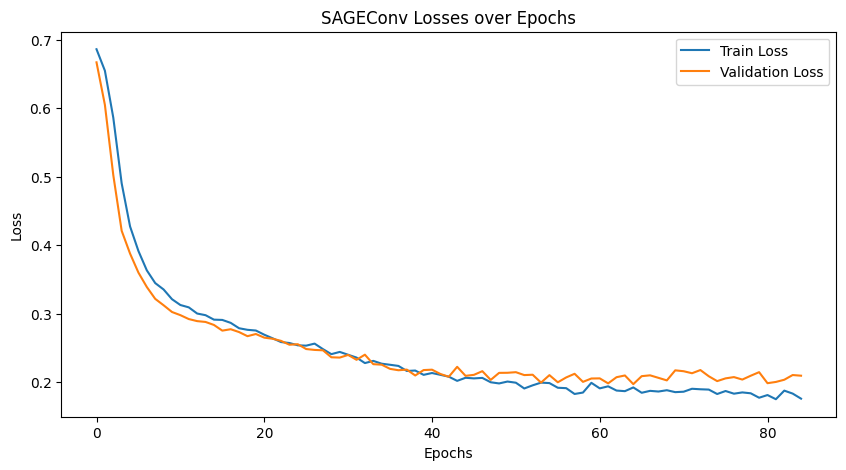

SAGEConv - Best Test Loss: 0.1970 achieved at Epoch: 065
The best model was from epoch 65 with a validation loss of 0.1970


In [22]:
hyperparams_sage = {
    "model_type": 'SAGEConv',  # Include model_type here
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.001,
    "num_epochs": 150,
    "patience": 20,
    "lr_decay_step": 50,
    "lr_decay_factor": 0.5,
    "loss_function": 'bpr',
    "classifier_type": 'lstm'
}
model_sage = Model(hidden_channels=64, conv_type='sage', classifier_type=hyperparams_sage["classifier_type"])
best_epoch_sage, best_val_loss_sage = train_model(model_sage, train_loader, test_loader, hyperparams_sage)
print(f"The best model was from epoch {best_epoch_sage} with a validation loss of {best_val_loss_sage:.4f}")


Training GATConv model on device: 'cpu'


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


GATConv - Epoch: 001, Train Loss: 0.6921 Test Loss: 0.6875


100%|██████████| 9/9 [00:02<00:00,  3.37it/s]


GATConv - Epoch: 002, Train Loss: 0.6832 Test Loss: 0.6626


100%|██████████| 9/9 [00:02<00:00,  3.39it/s]


GATConv - Epoch: 003, Train Loss: 0.6621 Test Loss: 0.6295


100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


GATConv - Epoch: 004, Train Loss: 0.6423 Test Loss: 0.6089


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


GATConv - Epoch: 005, Train Loss: 0.6309 Test Loss: 0.5966


100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


GATConv - Epoch: 006, Train Loss: 0.6235 Test Loss: 0.5894


100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


GATConv - Epoch: 007, Train Loss: 0.6193 Test Loss: 0.5840


100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


GATConv - Epoch: 008, Train Loss: 0.6143 Test Loss: 0.5768


100%|██████████| 9/9 [00:02<00:00,  3.85it/s]


GATConv - Epoch: 009, Train Loss: 0.6054 Test Loss: 0.5653


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


GATConv - Epoch: 010, Train Loss: 0.5907 Test Loss: 0.5478


100%|██████████| 9/9 [00:01<00:00,  4.92it/s]


GATConv - Epoch: 011, Train Loss: 0.5696 Test Loss: 0.5277


100%|██████████| 9/9 [00:01<00:00,  4.97it/s]


GATConv - Epoch: 012, Train Loss: 0.5517 Test Loss: 0.5181


100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


GATConv - Epoch: 013, Train Loss: 0.5407 Test Loss: 0.5168


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


GATConv - Epoch: 014, Train Loss: 0.5311 Test Loss: 0.5175


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


GATConv - Epoch: 015, Train Loss: 0.5229 Test Loss: 0.5131


100%|██████████| 9/9 [00:02<00:00,  3.93it/s]


GATConv - Epoch: 016, Train Loss: 0.5150 Test Loss: 0.5079


100%|██████████| 9/9 [00:01<00:00,  4.98it/s]


GATConv - Epoch: 017, Train Loss: 0.5063 Test Loss: 0.5027


100%|██████████| 9/9 [00:04<00:00,  2.09it/s]


GATConv - Epoch: 018, Train Loss: 0.5002 Test Loss: 0.4960


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


GATConv - Epoch: 019, Train Loss: 0.4957 Test Loss: 0.4983


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


GATConv - Epoch: 020, Train Loss: 0.4915 Test Loss: 0.4970


100%|██████████| 9/9 [00:02<00:00,  3.23it/s]


GATConv - Epoch: 021, Train Loss: 0.4893 Test Loss: 0.4964


100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


GATConv - Epoch: 022, Train Loss: 0.4886 Test Loss: 0.4899


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


GATConv - Epoch: 023, Train Loss: 0.4882 Test Loss: 0.4852


100%|██████████| 9/9 [00:01<00:00,  5.29it/s]


GATConv - Epoch: 024, Train Loss: 0.4875 Test Loss: 0.4834


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


GATConv - Epoch: 025, Train Loss: 0.4859 Test Loss: 0.4789


100%|██████████| 9/9 [00:01<00:00,  4.91it/s]


GATConv - Epoch: 026, Train Loss: 0.4856 Test Loss: 0.4799


100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


GATConv - Epoch: 027, Train Loss: 0.4856 Test Loss: 0.4803


100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


GATConv - Epoch: 028, Train Loss: 0.4843 Test Loss: 0.4839


100%|██████████| 9/9 [00:02<00:00,  3.92it/s]


GATConv - Epoch: 029, Train Loss: 0.4848 Test Loss: 0.4837


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


GATConv - Epoch: 030, Train Loss: 0.4840 Test Loss: 0.4827


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


GATConv - Epoch: 031, Train Loss: 0.4831 Test Loss: 0.4820


100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


GATConv - Epoch: 032, Train Loss: 0.4830 Test Loss: 0.4849


100%|██████████| 9/9 [00:01<00:00,  5.38it/s]


GATConv - Epoch: 033, Train Loss: 0.4829 Test Loss: 0.4838


100%|██████████| 9/9 [00:02<00:00,  4.38it/s]


GATConv - Epoch: 034, Train Loss: 0.4834 Test Loss: 0.4834


100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


GATConv - Epoch: 035, Train Loss: 0.4825 Test Loss: 0.4825


100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


GATConv - Epoch: 036, Train Loss: 0.4833 Test Loss: 0.4821


100%|██████████| 9/9 [00:02<00:00,  4.41it/s]


GATConv - Epoch: 037, Train Loss: 0.4825 Test Loss: 0.4803


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


GATConv - Epoch: 038, Train Loss: 0.4822 Test Loss: 0.4814


100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


GATConv - Epoch: 039, Train Loss: 0.4826 Test Loss: 0.4840


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


GATConv - Epoch: 040, Train Loss: 0.4822 Test Loss: 0.4798


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


GATConv - Epoch: 041, Train Loss: 0.4822 Test Loss: 0.4816


100%|██████████| 9/9 [00:01<00:00,  4.60it/s]


GATConv - Epoch: 042, Train Loss: 0.4826 Test Loss: 0.4797


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


GATConv - Epoch: 043, Train Loss: 0.4824 Test Loss: 0.4798


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


GATConv - Epoch: 044, Train Loss: 0.4821 Test Loss: 0.4796


100%|██████████| 9/9 [00:01<00:00,  5.02it/s]


GATConv - Epoch: 045, Train Loss: 0.4825 Test Loss: 0.4803
Early stopping!


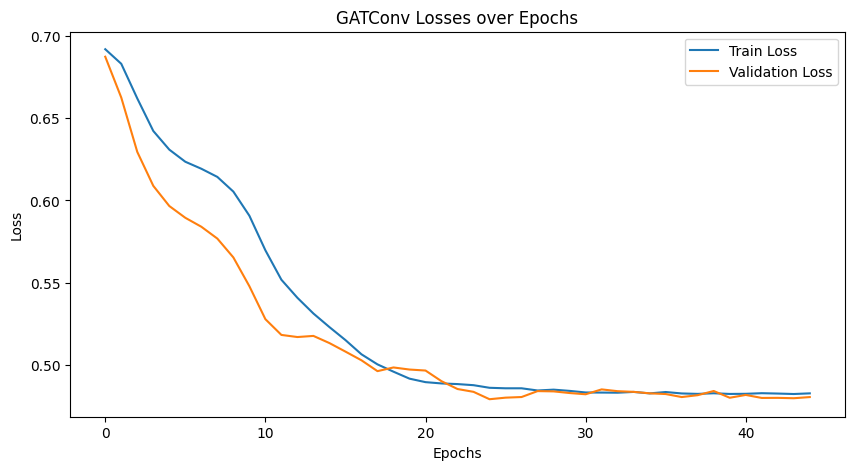

GATConv - Best Test Loss: 0.4789 achieved at Epoch: 025
The best model was from epoch 25 with a validation loss of 0.4789


In [27]:
hyperparams_gat = {
    "model_type": 'GATConv',  # Include model_type here
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "learning_rate": 0.001,
    "num_epochs": 150,
    "patience": 20,
    "lr_decay_step": 30,
    "lr_decay_factor": 0.5,
    "loss_function": 'bce',
    "classifier_type": 'lstm'

}

model_gat = Model(hidden_channels=64, conv_type='gat', classifier_type=hyperparams_gat["classifier_type"])
best_epoch_gat, best_val_loss_gat = train_model(model_gat, train_loader, test_loader, hyperparams_gat)
print(f"The best model was from epoch {best_epoch_gat} with a validation loss of {best_val_loss_gat:.4f}")


### Evaluation and validation of the results

In [30]:
# Sample usage
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}
auc_scores = evaluate_models_auc(models, val_loader, device)


evaluation_results = evaluate_accuracy(models, sampled_data, device)

for model_name, metrics in evaluation_results.items():
    print(f"Evaluation Results for {model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("-----------------------------")


prediction_counts = count_predictions(models, sampled_data, device)

for model_name, metrics in prediction_counts.items():
    print(f"Prediction Counts for {model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("-----------------------------")
precision_recall_results = evaluate_precision_recall(models, sampled_data, device)

for model_name, metrics in precision_recall_results.items():
    print(f"Model: {model_name}, Precision: {metrics['Precision']}, Recall: {metrics['Recall']}")

f1_score_results = evaluate_f1_score(models, sampled_data, device)

for model_name, metrics in f1_score_results.items():
    print(f"Model: {model_name}, F1 Score: {metrics['F1 Score']}")

Validation AUC for SAGEConv: 0.8640
-----------------------------
Validation AUC for GATConv: 0.8620
-----------------------------
Evaluation Results for SAGEConv:
Average probability for Positive Edges: 0.79905766248703
Accuracy for Positive Edges: 0.8519999980926514
Average probability for Negative Edges: 0.1360553354024887
Accuracy for Negative Edges: 0.8759999871253967
-----------------------------
Evaluation Results for GATConv:
Average probability for Positive Edges: 0.6266278028488159
Accuracy for Positive Edges: 0.8690000176429749
Average probability for Negative Edges: 0.3671596348285675
Accuracy for Negative Edges: 0.8550000190734863
-----------------------------
Prediction Counts for SAGEConv:
For Positive Edges: Number of 1's predicted: 852.0
For Positive Edges: Number of 0's predicted: 148.0
For Negative Edges: Number of 1's predicted: 124.0
For Negative Edges: Number of 0's predicted: 876.0
-----------------------------
Prediction Counts for GATConv:
For Positive Edges: N

In [15]:
# Prepare the data for the SAGE model
ground_truth_labels_index, ground_truth_labels, probabilities, binary_predictions = prepare_data(sampled_data, model_sage, device)

# Get the indices of positive and negative edges
positive_edge_indices, negative_edge_indices = get_positive_negative_indices(ground_truth_labels)
print(ground_truth_labels_index)
print(ground_truth_labels)
print(probabilities)
print(binary_predictions)

tensor([[ 553, 1509, 1058,  ..., 1713,  343,  215],
        [   8,   44,   24,  ...,    6,   35,   15]])
tensor([1., 1., 1.,  ..., 0., 0., 0.])
tensor([9.8604e-01, 4.3690e-01, 9.3042e-01,  ..., 2.9699e-03, 4.7572e-08,
        2.9635e-02])
tensor([1., 0., 1.,  ..., 0., 0., 0.])


Visualization of results

In [32]:
data = []
for i in range(ground_truth_labels_index.size(1)):
    src_sampled, dst_sampled = sampled_data["reviewer", "reviews", "product"].edge_label_index[:, i]
    src_val_data, dst_val_data = val_data["reviewer", "reviews", "product"].edge_label_index[:, i]

    true_label = "Positive" if ground_truth_labels[i] == 1 else "Negative"
    probability =probabilities[i]
    prediction = "Positive" if binary_predictions[i] == 1 else "Negative"

    data.append({
        "Masked From": src_sampled.item(),  # Converting tensor to scalar
        "Masked To": dst_sampled.item(),    
        "Node From": src_val_data.item(), 
        "Node To": dst_val_data.item(),    
        "Probability": round(probability.item(), 5),          
        "True Label": true_label,
        "Prediction": prediction
    })

df_predictions = pd.DataFrame(data)
df_predictions.head(20)

Masked From  Masked To  Node From  Node To  Probability True Label  \
0           363          8       1888        8      0.99425   Positive   
1           835         12       4329       12      0.83908   Positive   
2          1127         31       5908       31      0.90526   Positive   
3          1551         47       8228       47      0.61225   Positive   
4          1761         62       9072       62      0.99095   Positive   
5           896         12       4636       12      0.93621   Positive   
6           160          8        817        8      0.98986   Positive   
7            16          1        119        1      0.76509   Positive   
8           298          8       1532        8      0.99257   Positive   
9           238          8       1235        8      0.98906   Positive   
10         1472         39       7680       39      0.28253   Positive   
11         1298         33       6747       33      0.93378   Positive   
12          527          8       2723        8      0.95887   Positive   
13         1348         33       7007       33      0.82997   Positive   
14          349          8       1809        8      0.94551   Positive   
15          731          8       3771        8      0.99308   Positive   
16         1320         33       6904       33      0.95119   Positive   
17         1660         60       8667       60      0.99307   Positive   
18          804          9       4169        9      0.72246   Positive   
19         1010         20       5336       20      0.87697   Positive   

   Prediction  
0    Positive  
1    Positive  
2    Positive  
3    Positive  
4    Positive  
5    Positive  
6    Positive  
7    Positive  
8    Positive  
9    Positive  
10   Negative  
11   Positive  
12   Positive  
13   Positive  
14   Positive  
15   Positive  
16   Positive  
17   Positive  
18   Positive  
19   Positive

In [33]:
# Count the number of rows where True Label is positive and prediction is positive
true_positive_count = df_predictions[(df_predictions['True Label'] == 'Positive') & (df_predictions['Prediction'] == 'Positive')].shape[0]

# Count the number of rows where True Label is negative and prediction is negative
true_negative_count = df_predictions[(df_predictions['True Label'] == 'Negative') & (df_predictions['Prediction'] == 'Negative')].shape[0]

# Display the counts
print("True Positive Count:", true_positive_count)
print("True Negative Count:", true_negative_count)


True Positive Count: 852
True Negative Count: 876


In [ ]:
df_predictionss=pd.DataFrame()
# Create a new column to represent the combination of True Label and Prediction
df_predictionss['True_Prediction_Combo'] = df_predictions['True Label'] + '_' + df_predictions['Prediction']
user_combo_counts = df_predictionss.groupby('Node From')['True_Prediction_Combo'].nunique().reset_index()
user_combo_counts.columns = ['User', 'Common Combos']

user_combo_counts.head(10)


In [348]:
# Calculate the total number of common combinations across all users
total_common_combos = user_combo_counts['Common Combos'].sum()
print("Total Common Combinations:", total_common_combos)


Total Common Combinations: 1957


In [34]:
positive_predictions = df_predictions[df_predictions['Prediction'] == "Positive"]
product_recommendations_count = positive_predictions['Node To'].value_counts()
popularity_df = pd.DataFrame({'Product ID P': product_recommendations_count.index, 'Count_positive': product_recommendations_count.values})

negative_predictions = df_predictions[df_predictions['Prediction'] == "Negative"]
negative_node_to_popularity = negative_predictions['Node To'].value_counts()
negative_popularity_df = pd.DataFrame({'Product ID N': negative_node_to_popularity.index, 'Count_Negative': negative_node_to_popularity.values})

popularity_df = pd.concat([popularity_df, negative_popularity_df], axis=1)

popularity_df.head(10)

Product ID P  Count_positive  Product ID N  Count_Negative
0           8.0           385.0            39              33
1          33.0           134.0            51              27
2          20.0            60.0            61              26
3          12.0            48.0            42              26
4           1.0            33.0             6              23
5          61.0            31.0            46              23
6          60.0            25.0            24              23
7           9.0            24.0             5              22
8          36.0            23.0            41              21
9          62.0            21.0            47              21

Bad predictions

In [35]:
bad_predictions = df_predictions[df_predictions['True Label'] != df_predictions['Prediction']]
bad_predictions.head(300)

Masked From  Masked To  Node From  Node To  Probability True Label  \
10           1472         39       7680       39      0.28253   Positive   
25           1498         42       7909       42      0.08423   Positive   
27           1450         37       7543       37      0.10155   Positive   
32           1387         34       7232       34      0.11196   Positive   
35           1506         42       7944       42      0.23429   Positive   
...           ...        ...        ...      ...          ...        ...   
1955          545         32       2821       32      0.50172   Negative   
1956         1439          1       7486        1      0.76443   Negative   
1961         1192         12       6227       12      0.58273   Negative   
1978         1226          8       6360        8      0.95069   Negative   
1986         1817          4       9606        4      0.56114   Negative   

     Prediction  
10     Negative  
25     Negative  
27     Negative  
32     Negative  
35     Negative  
...         ...  
1955   Positive  
1956   Positive  
1961   Positive  
1978   Positive  
1986   Positive  

[272 rows x 7 columns]

In [36]:
# Count the occurrences of each product in bad_predictions
product_counts = bad_predictions['Node To'].value_counts()
bad_predictions_count_df = pd.DataFrame({'Product': product_counts.index, 'Occurrences': product_counts.values})
bad_predictions_count_df = bad_predictions_count_df.sort_values(by='Occurrences', ascending=False)

bad_predictions_count_df.head(10)


Product  Occurrences
0       39           16
1       33           14
2       61           12
3       44           11
4       36           11
5       31           10
6       42           10
7        8           10
8       35           10
9       30            9

In [37]:
# Count the number of positive and negative connections for each user
user_counts = df_predictions.groupby(['Node From', 'True Label'])['True Label'].count().unstack(fill_value=0)
user_counts['Total Count'] = user_counts['Positive'] + user_counts['Negative']

# Sort users by total count in descending order
most_popular_users = user_counts.sort_values(by='Total Count', ascending=False).reset_index()
most_popular_users.columns = ['User', 'Positive True Count', 'Negative True Count', 'Total Count']

popular_user_ids = most_popular_users['User'].tolist()
popular_user_predictions = df_predictions[df_predictions['Node From'].isin(popular_user_ids)]
popular_user_prediction_counts = popular_user_predictions.groupby(['Node From', 'Prediction'])['Prediction'].count().unstack(fill_value=0)
popular_user_prediction_counts.index.name = 'User'

# Merge the popular user prediction counts with the most_popular_users DataFrame
most_popular_users = pd.merge(most_popular_users, popular_user_prediction_counts, left_on='User', right_index=True, how='left')
most_popular_users.rename(columns={'Negative': 'Negative Predictions', 'Positive': 'Positive Predictions'}, inplace=True)
most_popular_users.fillna(0, inplace=True)

# Calculate the total count of positive predictions across all users
total_positive_predictions = most_popular_users['Positive Predictions'].sum()
total_negative_predictions = most_popular_users['Negative Predictions'].sum()

# Display the total counts
print("Total Positive Predictions:", total_positive_predictions)
print("Total Negative Predictions:", total_negative_predictions)

most_popular_users.head(10)


Total Positive Predictions: 976
Total Negative Predictions: 1024


User  Positive True Count  Negative True Count  Total Count  \
0  2821                    2                    1            3   
1  7766                    2                    1            3   
2  5371                    2                    1            3   
3  2180                    2                    1            3   
4  3402                    2                    1            3   
5  2294                    2                    0            2   
6  8815                    1                    1            2   
7  9103                    2                    0            2   
8  3480                    1                    1            2   
9  4056                    1                    1            2   

   Negative Predictions  Positive Predictions  
0                     1                     2  
1                     3                     0  
2                     3                     0  
3                     2                     1  
4                     2                     1  
5                     0                     2  
6                     1                     1  
7                     1                     1  
8                     1                     1  
9                     1                     1

In [22]:
user_id =7  

# Extract the relevant data for the user
user_data = sampled_data["reviewer", "reviews", "product"]
user_mask = user_data.edge_index[0] == user_id

# Get the product IDs that the user has interacted with
user_interacted_products = user_data.edge_index[1][user_mask].tolist()

print(f"User {user_id} has interacted with the following products:")
for product_id in user_interacted_products:
    print(f"Product ID: {product_id}")


User 7 has interacted with the following products:
Product ID: 1


In [42]:
f1_score_results = evaluate_f1_score(models, sampled_data, device)

# Ispis rezultata
for model_name, metrics in f1_score_results.items():
    print(f"Model: {model_name}, F1 Score: {metrics['F1 Score']}")

Model: SAGEConv, F1 Score: 0.8623481781376517
Model: GATConv, F1 Score: 0.8629592850049653


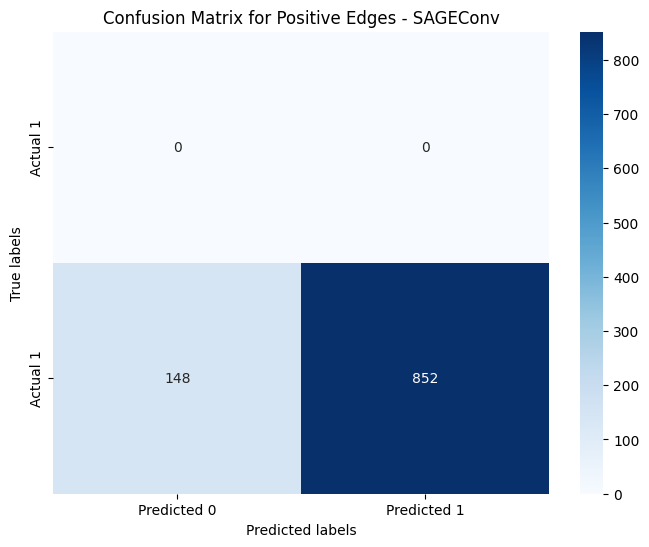

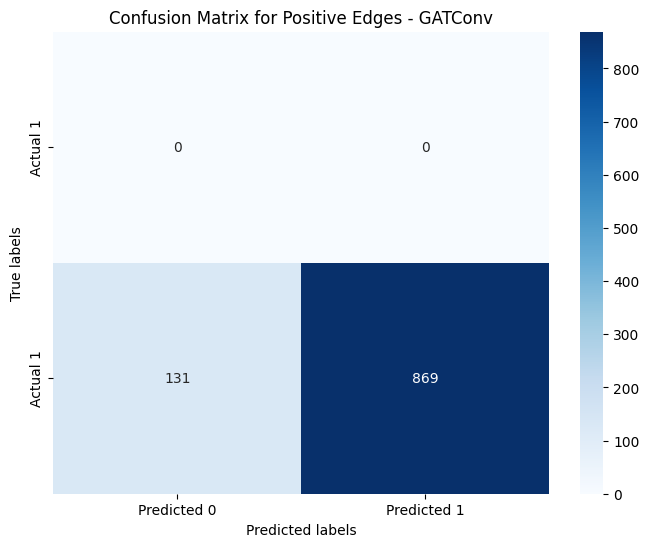

In [43]:
plot_confusion_matrix_for_positive_edges(models, sampled_data, device)

## Preparing validation functions for GUI

In [51]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Adding nodes to the graph
    for node_type in data.node_types:
        ids = data[node_type].node_id
        G.add_nodes_from([(node_type + "_" + str(i.item()), {"type": node_type}) for i in ids])

    # Adding edges to the graph
    for (src_type, edge_type, dst_type), edge_index in data.edge_index_dict.items():
        edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
        G.add_edges_from([(src_type + "_" + str(src), dst_type + "_" + str(dst), {"type": edge_type}) for src, dst in edges])

    return G

def plot_reduced_graph(G, num_edges=600, save_path=None):
    """
    Plot a reduced graph focusing on a specific number of connections (edges).
    
    Args:
    - G (networkx.Graph): The input graph.
    - num_edges (int, optional): The number of edges to include in the visualization. Defaults to 200.
    
    Returns:
    None
    """
    
    plt.figure(figsize=(15, 15))
    
    # Convert edges to a list and then select a sample
    edges_list = list(G.edges())
    edges_sample = random.sample(edges_list, min(num_edges, len(edges_list)))
    nodes_in_sample = set([u for u, v in edges_sample] + [v for u, v in edges_sample])

    # Subset of the graph for visualization
    G_sample = G.subgraph(nodes_in_sample)
    pos = nx.spring_layout(G_sample, k=0.5)

    color_map = {
        'reviewer': 'green',
        'product': 'blue'
    }

    # Draw nodes
    for node_type, color in color_map.items():
        nx.draw_networkx_nodes(G_sample, pos, 
                               nodelist=[n for n, d in G_sample.nodes(data=True) if d['type'] == node_type],
                               node_size=100,
                               node_color=color,
                               label=node_type)

    # Draw only the sampled edges
    nx.draw_networkx_edges(G_sample, pos, 
                           edgelist=edges_sample,
                           width=1.5, alpha=0.6)

    plt.legend()
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, dpi=100)
    else:
        plt.show()

# Example usage:
# plot_reduced_graph(G, num_edges=200)  # For 200 connections


In [52]:
G_val = hetero_to_networkx(sampled_data)
print(G_val)

MultiDiGraph with 9148 nodes and 14000 edges


Real Validation Data:


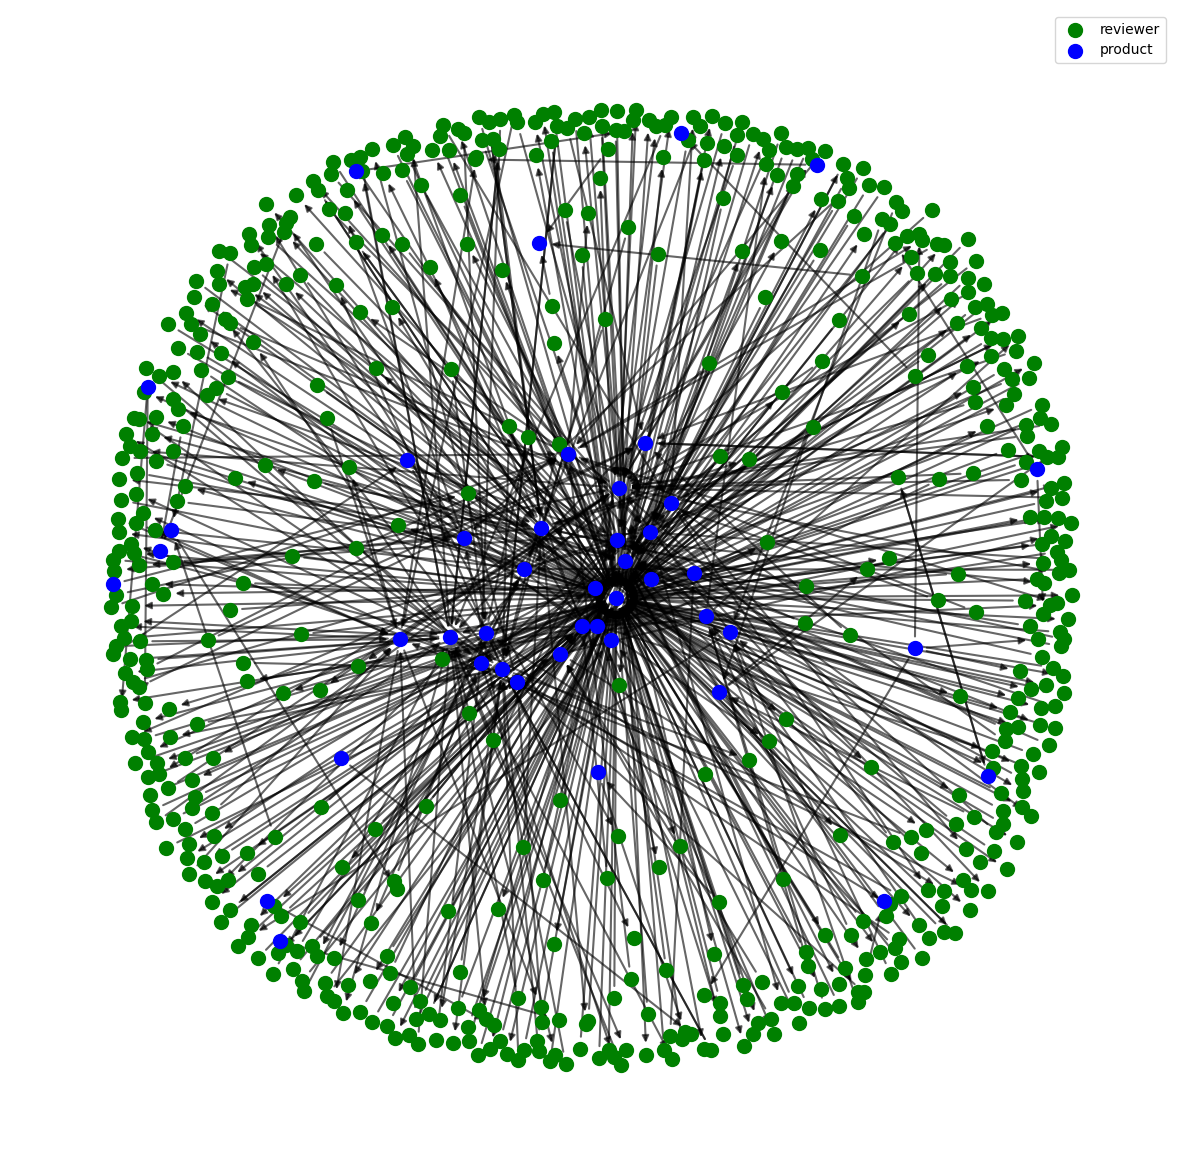

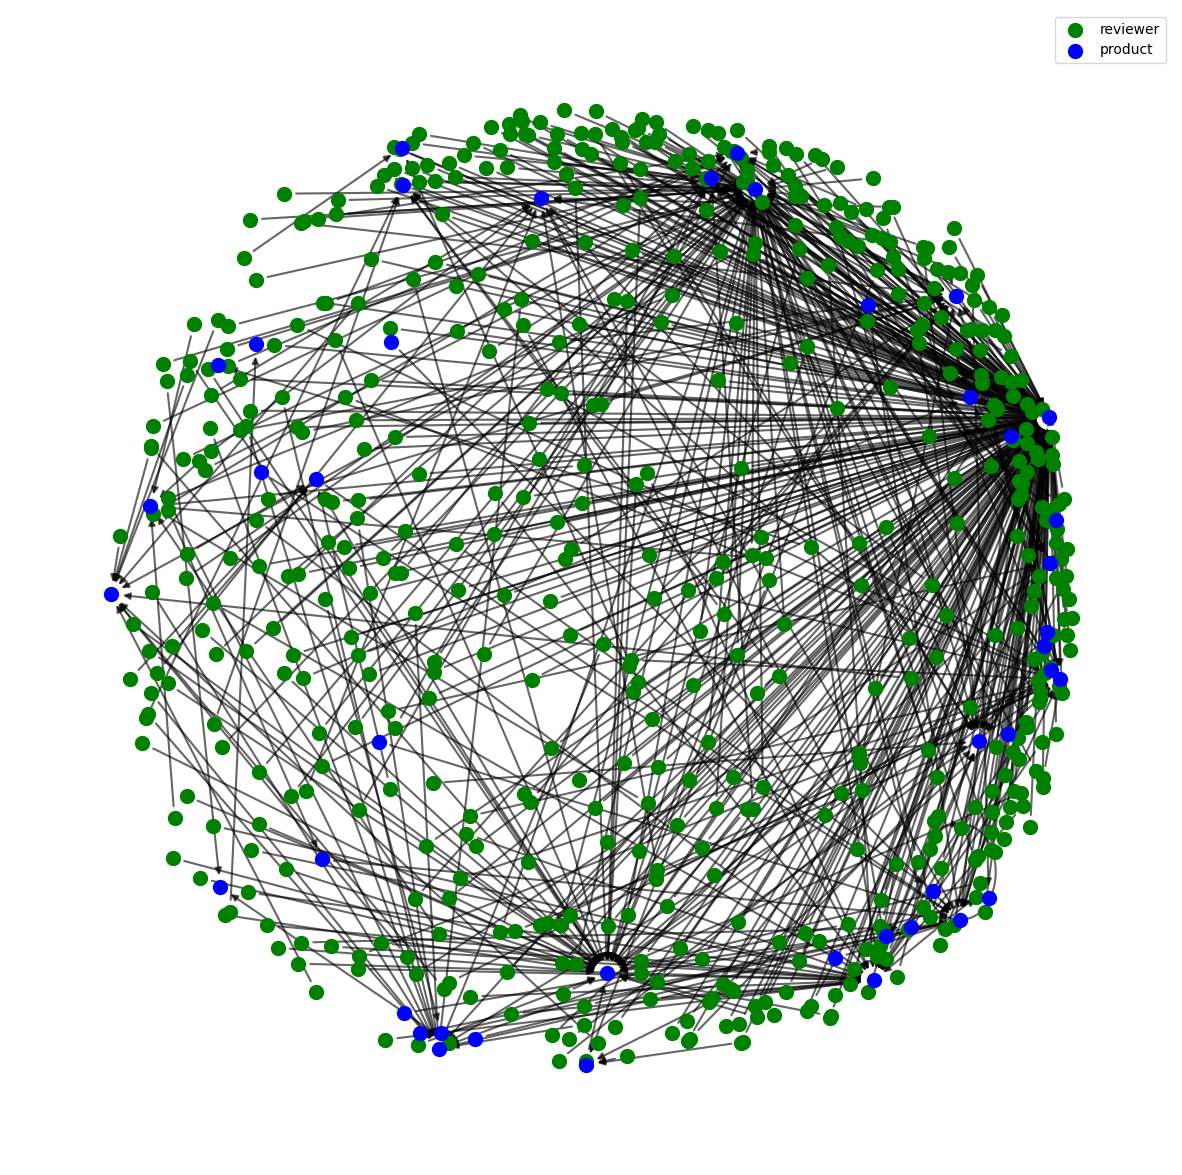

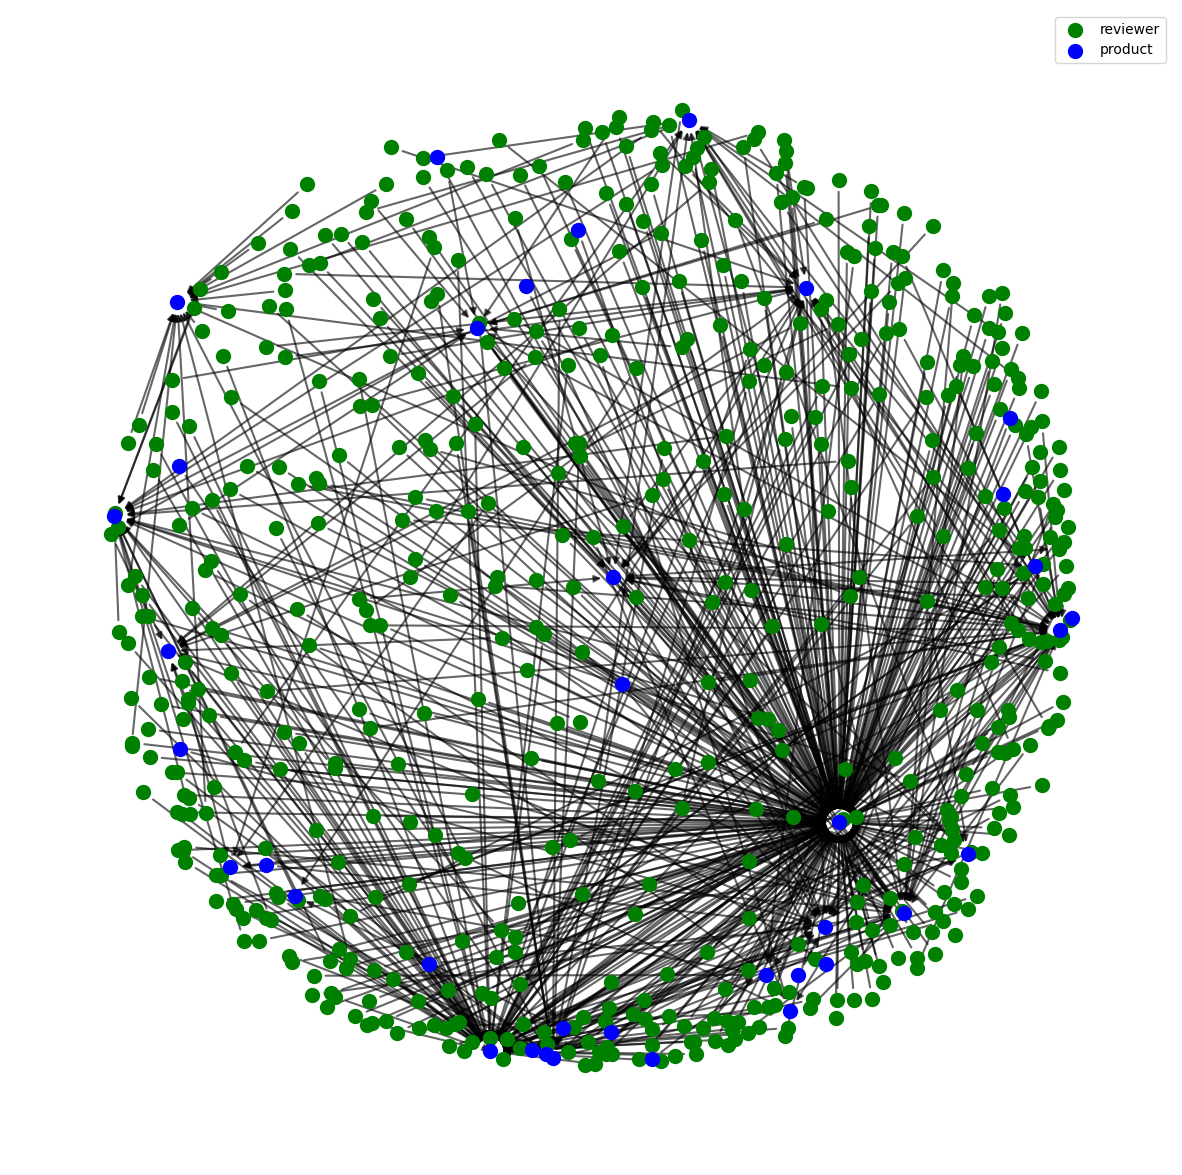

In [53]:
def generate_predicted_graph(model, sampled_data, device):
    model = model.to(device)
    model.eval()

    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)

    positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
    positive_preds = binary_predictions[positive_edge_indices]
    positive_true = ground_truth_labels[positive_edge_indices]

    true_positive_mask = (positive_preds == positive_true) & (positive_true == 1)
    true_positive_indices = positive_edge_indices[true_positive_mask]
    true_positive_edge_pairs = sampled_data["reviewer", "reviews", "product"].edge_label_index[:, true_positive_indices].cpu().numpy()

    G = nx.DiGraph()

    for reviewer_id in sampled_data["reviewer"]["node_id"].cpu().numpy():
        G.add_node(reviewer_id, type="reviewer")

    for product_id in sampled_data["product"]["node_id"].cpu().numpy():
        G.add_node(product_id, type="product")

    for source, target in true_positive_edge_pairs.T:
        G.add_edge(source, target)

    return G

def plot_all_models(models, sampled_data, device):
    # Plot real validation data first
    G_val = hetero_to_networkx(sampled_data)  # Assuming you want to visualize the sampled_data as validation data
    print("Real Validation Data:")
    plot_reduced_graph(G_val, save_path="Val_Graph.png")

    # Plot for each model
    for model_name, model in models.items():
        G = generate_predicted_graph(model, sampled_data, device)
        plot_reduced_graph(G, save_path=f"PredictedGraph_{model_name}.png")

# Sample usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}
plot_all_models(models, sampled_data, device)


Preparing results for validation and evaluation in tkinter window

In [54]:
def real_product_appearances(sampled_data):
    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    destination_nodes = edge_indices[1].cpu().numpy()

    product_counts = Counter(destination_nodes)
    return product_counts

def predicted_product_appearances_for_model(model, sampled_data, device):
    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)

    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    destination_nodes = edge_indices[1].cpu().numpy()
    binary_predictions = binary_predictions.cpu().numpy()

    predicted_product_counts = Counter(dest for dest, prediction in zip(destination_nodes, binary_predictions) if prediction == 1)
    return predicted_product_counts

def generate_comparison_table(models, sampled_data, device):
    real_counts = real_product_appearances(sampled_data)

    data = {
        "Real Appearances": [real_counts.get(product, 0) for product in real_counts]
    }

    for model_name, model_instance in models.items():
        predicted_counts = predicted_product_appearances_for_model(model_instance, sampled_data, device)
        data[model_name] = [predicted_counts.get(product, 0) for product in real_counts]

    df = pd.DataFrame(data, index=real_counts.keys())
    df.index.name = "Product"
    
    # Sort by real appearances in descending order
    df = df.sort_values(by="Real Appearances", ascending=False)
    return df

models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}

comparison_table = generate_comparison_table(models, sampled_data, device)
print(comparison_table)



         Real Appearances  SAGEConv  GATConv
Product                                     
8                     393       385      377
33                    144       134      128
20                     70        60       60
12                     63        48       49
61                     57        31       48
39                     49        16       30
1                      44        33       35
60                     43        25       39
36                     40        23       26
55                     39        19       18
57                     35        16       10
9                      33        24       24
31                     32        20       23
45                     31        13       19
51                     31         4        0
42                     31         5       16
62                     31        21       26
30                     29        21       27
35                     28        11       19
54                     27         9       12
24        

In [55]:
def real_reviewer_appearances(sampled_data):
    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    source_nodes = edge_indices[0].cpu().numpy()  # Focusing on source nodes (reviewers)

    reviewer_counts = Counter(source_nodes)
    return reviewer_counts

def predicted_reviewer_appearances_for_model(model, sampled_data, device):
    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)

    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    source_nodes = edge_indices[0].cpu().numpy()  # Focusing on source nodes (reviewers)
    binary_predictions = binary_predictions.cpu().numpy()

    predicted_reviewer_counts = Counter(src for src, prediction in zip(source_nodes, binary_predictions) if prediction == 1)
    return predicted_reviewer_counts

def generate_comparison_table(models, sampled_data, device):
    real_counts = real_reviewer_appearances(sampled_data)

    data = {
        "Real Appearances": [real_counts.get(reviewer, 0) for reviewer in real_counts]
    }

    for model_name, model_instance in models.items():
        predicted_counts = predicted_reviewer_appearances_for_model(model_instance, sampled_data, device)
        data[model_name] = [predicted_counts.get(reviewer, 0) for reviewer in real_counts]

    df = pd.DataFrame(data, index=real_counts.keys())
    df.index.name = "Reviewer"
    
    # Sort by real appearances in descending order
    df = df.sort_values(by="Real Appearances", ascending=False)
    return df

# Usage with your models
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}

comparison_table = generate_comparison_table(models, sampled_data, device)
print(comparison_table)


          Real Appearances  SAGEConv  GATConv
Reviewer                                     
1484                     3         0        2
545                      3         2        2
1017                     3         0        0
661                      3         1        1
421                      3         1        1
1199                     2         0        1
85                       2         2        2
257                      2         1        1
173                      2         0        0
1206                     2         2        2
768                      2         0        0
1313                     2         1        0
1336                     2         0        0
785                      2         1        2
1637                     2         1        0
578                      2         2        2
1235                     2         1        1
1361                     2         1        1
1028                     2         0        1
1443                     2        

In [56]:
def real_reviewer_product_connections(val_loader):
    # Extract real connections from val_loader
    # Adjust this part to match the actual structure of your val_loader
    real_connections = set()
    for batch in val_loader:
        edge_indices = batch["reviewer", "reviews", "product"].edge_label_index
        source_nodes = edge_indices[0].cpu().numpy()
        destination_nodes = edge_indices[1].cpu().numpy()
        for src, dest in zip(source_nodes, destination_nodes):
            real_connections.add((src, dest))
    return real_connections

def predicted_reviewer_product_connections(model, sampled_data, device):
    # Extract predicted connections from sampled_data using the model
    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
    edge_indices = sampled_data["reviewer", "reviews", "product"].edge_label_index
    source_nodes = edge_indices[0].cpu().numpy()
    destination_nodes = edge_indices[1].cpu().numpy()
    binary_predictions = binary_predictions.cpu().numpy()

    predicted_connections = set((src, dest) for src, dest, prediction in zip(source_nodes, destination_nodes, binary_predictions) if prediction == 1)
    return predicted_connections

def compare_with_val_loader(models, sampled_data, val_loader, device):
    real_connections = real_reviewer_product_connections(val_loader)

    data = {}
    for model_name, model_instance in models.items():
        predicted_connections = predicted_reviewer_product_connections(model_instance, sampled_data, device)
        correct_predictions = real_connections.intersection(predicted_connections)
        data[model_name] = len(correct_predictions)

    return pd.Series(data, name="Correct Predictions")

# Usage with your models
models = {
    "SAGEConv": model_sage,
    "GATConv": model_gat
}

comparison_results = compare_with_val_loader(models, sampled_data, val_loader, device)
print(comparison_results)


SAGEConv     974
GATConv     1011
Name: Correct Predictions, dtype: int64


Function for calculating probability of interaction between specific user and all products

In [59]:
def get_user_recommendation_probabilities(model, user_id, sampled_data, device):
    model.eval()
    model.to(device)
    user_recommendations = []

    with torch.no_grad():
        item_ids = sampled_data['product'].node_id.to(device)

        # Generate user-item pairs for the specified user
        user_item_pairs = [(user_id, item_id.item()) for item_id in item_ids]

        for _, item_id in user_item_pairs:
            edge_label_index = torch.tensor([[user_id], [item_id]], device=device)

            # Create pseudo sampled_data with edge_label_index
            pseudo_sampled_data = sampled_data.clone()
            pseudo_sampled_data['reviewer', 'reviews', 'product'].edge_label_index = edge_label_index

            pred = model(pseudo_sampled_data)
            prob = torch.sigmoid(pred).item()
            user_recommendations.append((item_id, prob))

    user_recommendations.sort(key=lambda x: x[1], reverse=True)
    return user_recommendations

# Example usage
user_id = 10  # Replace with the ID of the user you're interested in
recommendations = get_user_recommendation_probabilities(model_sage, user_id, sampled_data, device)
import pandas as pd

def filter_and_display_recommendations(recommendations, probability_threshold=0.5, top_n=None):
    # Filter recommendations with probability greater than the threshold
    filtered_recommendations = [(item_id, prob) for item_id, prob in recommendations if prob > probability_threshold]

    # Convert to DataFrame for better display
    df = pd.DataFrame(filtered_recommendations, columns=['Item ID', 'Probability'])

    # If top_n is specified, select only the top_n rows
    if top_n is not None:
        df = df.head(top_n)

    return df

# Example usage
probability_threshold = 0.5
top_n = 10  # Set to None if you don't want to limit the number of recommendations
filtered_df = filter_and_display_recommendations(recommendations, probability_threshold)
print(filtered_df)


Empty DataFrame
Columns: [Item ID, Probability]
Index: []


In [173]:
cf_recommendations_df = pd.read_csv("recommendations_CF.csv")


## GUI

Validation AUC for SAGEConv: 0.8640
-----------------------------
Validation AUC for GATConv: 0.8620
-----------------------------
Validation AUC for SAGEConv: 0.8640
-----------------------------
Validation AUC for GATConv: 0.8620
-----------------------------


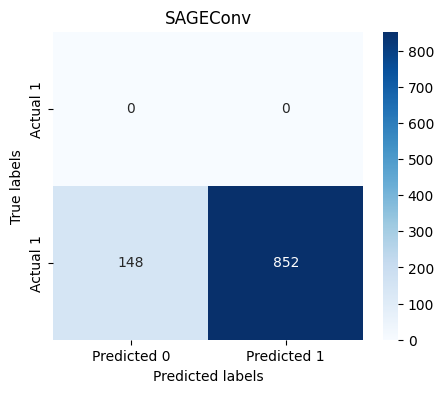

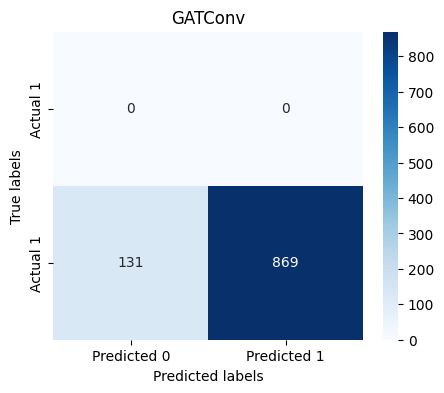

In [71]:
def show_results():
    selected_model = model_combobox.get()
    
    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return
    
    # Clear existing text in the results_text widget
    results_text.delete(1.0, tk.END)

    # AUC Results
    auc_result = evaluate_models_auc({selected_model: models[selected_model]}, [sampled_data], device)
    results_text.insert(tk.END, f"Validation AUC for {selected_model}: {auc_result[selected_model]:.4f}\n")
    results_text.insert(tk.END, "-"*30 + "\n")

    # Accuracy Results
    acc_results = evaluate_accuracy({selected_model: models[selected_model]}, sampled_data, device)
    for key, value in acc_results[selected_model].items():
        results_text.insert(tk.END, f"{key}: {value:.4f}\n")
    results_text.insert(tk.END, "-"*30 + "\n")

    # Count Predictions Results
    pred_counts = count_predictions({selected_model: models[selected_model]}, sampled_data, device)
    for key, value in pred_counts[selected_model].items():
        results_text.insert(tk.END, f"{key}: {value}\n")

def display_confusion_matrix():
    selected_model = model_combobox.get()
    
    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return

    _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, models[selected_model], device)
    positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
    
    positive_preds = binary_predictions[positive_edge_indices]
    true_positive_labels = torch.ones_like(positive_preds)
    
    cm = confusion_matrix(true_positive_labels.cpu().numpy(), positive_preds.cpu().numpy())

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 1', 'Actual 1'])
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')
    ax.set_title(f'Confusion Matrix for Positive Edges - {selected_model}')

    # Creating new window for confusion matrix
    cm_window = tk.Toplevel(root)
    cm_window.title(f"Confusion Matrix - {selected_model}")
    canvas = FigureCanvasTkAgg(fig, master=cm_window)
    canvas.draw()
    canvas.get_tk_widget().pack()
def display_model_graphs():
    selected_model = model_combobox.get()
    
    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return
    
    # Assuming plot_all_models has been called earlier and images are already saved
    val_image = Image.open("Val_Graph.png")
    model_image = Image.open(f"PredictedGraph_{selected_model}.png")

    # Resize the images to make them smaller while keeping the aspect ratio
    base_width = 600
    val_image = val_image.resize((base_width, int((base_width / val_image.width) * val_image.height)))
    model_image = model_image.resize((base_width, int((base_width / model_image.width) * model_image.height)))
    
    val_photo = ImageTk.PhotoImage(val_image)
    model_photo = ImageTk.PhotoImage(model_image)
    
    # Creating new window for model's graph comparison with real data graph
    graph_window = tk.Toplevel(root)
    graph_window.title(f"Graph Comparison - {selected_model}")
    
    # Adding descriptive text for the graphs
    tk.Label(graph_window, text="Real Connections", font=("Arial", 16)).grid(row=0, column=0, padx=10, pady=10)
    tk.Label(graph_window, text="Predicted Connections", font=("Arial", 16)).grid(row=0, column=1, padx=10, pady=10)
    
    # Displaying Validation Graph (Real Connections)
    val_label = tk.Label(graph_window, image=val_photo)
    val_label.image = val_photo  # Keep a reference to prevent garbage collection
    val_label.grid(row=1, column=0, padx=10, pady=10)
    
    # Displaying Model's Graph (Predicted Connections)
    model_label = tk.Label(graph_window, image=model_photo)
    model_label.image = model_photo
    model_label.grid(row=1, column=1, padx=10, pady=10)

def display_comparison_table():
    selected_model = model_combobox.get()

    if selected_model not in models:
        messagebox.showerror("Error", f"{selected_model} model not available!")
        return
    
    df = generate_comparison_table({selected_model: models[selected_model]}, sampled_data, device)

    # Creating a new window for the comparison table
    table_window = tk.Toplevel(root)
    table_window.title(f"Real vs. Predicted Data - {selected_model}")

    # Create and pack the treeview
    tree = ttk.Treeview(table_window, columns=('User', 'Real Appearances', selected_model), show='headings')
    tree.heading('User', text='User')
    tree.heading('Real Appearances', text='Real Appearances')
    tree.heading(selected_model, text=selected_model)

    for index, row in df.iterrows():
        tree.insert("", tk.END, values=(index, row["Real Appearances"], row[selected_model]))

    tree.pack(pady=20)



#-------------------------------------------------------NEW WINDOW--------------------------------------------------------------------------------
def show_comparison_window():
    comp_window = tk.Toplevel(root)
    comp_window.title("Model Comparisons")

    ttk.Label(comp_window, text="Model Comparisons:", font=("Arial", 16)).pack(pady=20)
    
    # Button to compare models using the AUC
    ttk.Button(comp_window, text="Compare AUC", command=compare_auc).pack(pady=10)

    # Button to compare models using Accuracy
    ttk.Button(comp_window, text="Compare Accuracy", command=compare_accuracy).pack(pady=10)

    # Button to compare models using Count Predictions
    ttk.Button(comp_window, text="Compare Count Predictions", command=compare_pred_counts).pack(pady=10)
     # Button to compare models' confusion matrices
    ttk.Button(comp_window, text="Compare Confusion Matrices", command=compare_confusion_matrices).pack(pady=10)

    # Button to compare models' graphs
    ttk.Button(comp_window, text="Compare Graphs", command=compare_graphs).pack(pady=10)

    # Button to compare models' Real vs Predicted data
    ttk.Button(comp_window, text="Compare Real vs Predicted", command=lambda: compare_real_vs_predicted(models, sampled_data, device)).pack(pady=10)
    
def compare_auc():
    all_aucs = evaluate_models_auc(models, [sampled_data], device)
    message = "AUC Comparison:\n\n" + "\n".join(f"{model}: {auc:.4f}" for model, auc in all_aucs.items())
    update_comparison_results(message)

def compare_accuracy():
    all_accuracies = evaluate_accuracy(models, sampled_data, device)
    message = "Accuracy Comparison:\n\n" + "\n".join(f"{model}:\n" + "\n".join(f"{key}: {value:.4f}" for key, value in acc.items()) for model, acc in all_accuracies.items())
    update_comparison_results(message)

def compare_pred_counts():
    all_pred_counts = count_predictions(models, sampled_data, device)
    message = "Predictions Count Comparison:\n\n"
    for model_name, pred_values in all_pred_counts.items():
        message += f"{model_name}:\n" + "\n".join(f"{key}: {value}" for key, value in pred_values.items()) + "\n" + "-"*30 + "\n"
    update_comparison_results(message)

def compare_confusion_matrices():
    cm_window = tk.Toplevel(root)
    cm_window.title("Confusion Matrices Comparison")

    for index, (model_name, model) in enumerate(models.items()):
        _, ground_truth_labels, _, binary_predictions = prepare_data(sampled_data, model, device)
        positive_edge_indices, _ = get_positive_negative_indices(ground_truth_labels)
        positive_preds = binary_predictions[positive_edge_indices]
        true_positive_labels = torch.ones_like(positive_preds)
        cm = confusion_matrix(true_positive_labels.cpu().numpy(), positive_preds.cpu().numpy())
        
        # Plotting
        fig, ax = plt.subplots(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax,
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['Actual 1', 'Actual 1'])
        ax.set_ylabel('True labels')
        ax.set_xlabel('Predicted labels')
        ax.set_title(f'{model_name}')
        
        # Embed the plot in the tkinter window
        canvas = FigureCanvasTkAgg(fig, master=cm_window)
        canvas.draw()
        canvas.get_tk_widget().grid(row=0, column=index)
        ttk.Label(cm_window, text=model_name, font=("Arial", 14)).grid(row=1, column=index)

def compare_graphs():
    graph_window = tk.Toplevel(root)
    graph_window.title("Graphs Comparison")

    for index, (model_name, _) in enumerate(models.items()):
        # Assuming you've called plot_all_models before and images are already saved
        model_image = Image.open(f"PredictedGraph_{model_name}.png")
        
        base_width = 500
        model_image = model_image.resize((base_width, int((base_width / model_image.width) * model_image.height)))
        model_photo = ImageTk.PhotoImage(model_image)
        
        # Displaying Model's Graph
        model_label = tk.Label(graph_window, image=model_photo)
        model_label.image = model_photo
        model_label.grid(row=0, column=index, padx=10, pady=10)
        ttk.Label(graph_window, text=model_name, font=("Arial", 14)).grid(row=1, column=index)

def compare_real_vs_predicted(models, sampled_data, device):
    # Generišemo DataFrame za upoređivanje
    df = generate_comparison_table(models, sampled_data, device)

    # Kreiranje novog prozora za tabelu upoređivanja
    table_window = tk.Toplevel(root)
    table_window.title("Real vs. Predicted Data - All Models")

    # Kreiranje i postavljanje treeview
    tree = ttk.Treeview(table_window, columns=['User', 'Real Appearances'] + list(models.keys()), show='headings')
    tree.heading('User', text='User')
    tree.heading('Real Appearances', text='Real Appearances')
    
    for model_name in models:
        tree.heading(model_name, text=model_name)
    
    for index, row in df.iterrows():
        tree.insert("", tk.END, values=[index] + row.tolist())

    tree.pack(pady=20)


def update_comparison_results(message):
    for widget in comparison_results_frame.winfo_children():
        widget.destroy()
    results_text = tk.Text(comparison_results_frame,  wrap=tk.WORD, width=50, height=15)
    results_text.pack(fill='both', expand=True)
    results_text.insert(tk.END, message)

#----------------------------------------------Recommendations-------------------------------------------------------------------------

# Function for getting and showing recommendations
def get_and_show_recommendations():
    # Clear previous recommendations
    for i in rec_tree.get_children():
        rec_tree.delete(i)

    try:
        # Get the user ID from the ComboBox
        user_id = int(user_id_combobox.get())

        if user_id >= total_unique_users:
            raise ValueError("User ID exceeds the total number of unique users")

        selected_model_name = rec_model_combobox.get()

        # Map combobox selection to actual model object
        model_dict = {"SAGEConv": model_sage, "GATConv": model_gat}
        if selected_model_name in model_dict:
            selected_model = model_dict[selected_model_name]

            # Show processing message
            status_label.config(text="Evaluating recommendations...")
            recommendation_tab.update_idletasks()

            recommendations = get_user_recommendation_probabilities(selected_model, user_id, sampled_data, device)
            for item_id, prob in recommendations:
                # Determine the tag based on probability
                tag = 'green' if prob > 0.5 else 'red'
                rec_tree.insert("", tk.END, values=(item_id, prob, ""), tags=(tag,))

            # Clear processing message
            status_label.config(text="")
        else:
            messagebox.showerror("Error", f"{selected_model_name} model not available!")
    except ValueError as ve:
        messagebox.showerror("Error", str(ve))



#-------------------------------------------------------GUI Setup-------------------------------------------------------------------------

# Initialize the main GUI window
root = tk.Tk()
root.title("Model validation and recommendation")

# Create a Notebook for tabs
notebook = ttk.Notebook(root)
notebook.pack(pady=10, expand=True)

# Tabs
evaluation_tab = ttk.Frame(notebook)
comparison_tab = ttk.Frame(notebook)
recommendation_tab = ttk.Frame(notebook)
notebook.add(evaluation_tab, text='Model Evaluation')
notebook.add(comparison_tab, text='Model Comparison')
notebook.add(recommendation_tab, text='Recommendation System')

#-------------------------------------------------------Model Evaluation Tab---------------------------------------------------------------

# Dropdown for model selection
ttk.Label(evaluation_tab, text="Select Model:").pack(pady=10)
model_combobox = ttk.Combobox(evaluation_tab, values=list(models.keys()))
model_combobox.pack(pady=10)
model_combobox.set("SAGEConv")  # Default selected value

# Button to trigger the evaluation
btn_evaluate = ttk.Button(evaluation_tab, text="Evaluate", command=show_results)
btn_evaluate.pack(pady=10)

# Button to display the confusion matrix
btn_cm = ttk.Button(evaluation_tab, text="Show Confusion Matrix", command=display_confusion_matrix)
btn_cm.pack(pady=10)

# Button to display the model's graph in comparison with real data graph
btn_graphs = ttk.Button(evaluation_tab, text="Show Graphs", command=display_model_graphs)
btn_graphs.pack(pady=10)

# Button to show Real vs. Predicted Data
btn_comparison = ttk.Button(evaluation_tab, text="Show Real vs. Predicted Data", command=display_comparison_table)
btn_comparison.pack(pady=10)

# Text widget for displaying results
results_text = tk.Text(evaluation_tab, wrap=tk.WORD, width=50, height=15)
results_text.pack(pady=10)


#-------------------------------------------------------Model Comparison Tab Setup-------------------------------------------------------

# Label and buttons for model comparisons
ttk.Label(comparison_tab, text="Model Comparisons:", font=("Arial", 16)).pack(pady=10)
ttk.Button(comparison_tab, text="Compare AUC", command=compare_auc).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Accuracy", command=compare_accuracy).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Count Predictions", command=compare_pred_counts).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Confusion Matrices", command=compare_confusion_matrices).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Graphs", command=compare_graphs).pack(pady=10)
ttk.Button(comparison_tab, text="Compare Real vs Predicted", command=lambda: compare_real_vs_predicted(models, sampled_data, device)).pack(pady=10)

# Results frame in comparison tab
comparison_results_frame = ttk.Frame(comparison_tab)
comparison_results_frame.pack(pady=10, fill='both', expand=True)

#-------------------------------------------------------Recommendation System Tab Setup----------------------------------------------------

total_unique_users = data['reviewer'].node_id.size(0)

# Extract unique real user IDs from df_predictions
unique_real_user_ids = df_predictions['Node From'].unique().tolist()

# Exclude user IDs greater than the total number of unique users
unique_real_user_ids = [uid for uid in unique_real_user_ids if uid < total_unique_users]

unique_real_user_ids = df_predictions['Node From'].unique().tolist()

# Recommendation System Tab Setup
ttk.Label(recommendation_tab, text="Select Model:").pack(pady=10)
rec_model_combobox = ttk.Combobox(recommendation_tab, values=["SAGEConv", "GATConv"])
rec_model_combobox.pack(pady=10)
rec_model_combobox.set("SAGEConv")  # Default selected value

# Dropdown for user ID selection
ttk.Label(recommendation_tab, text="Select User ID:").pack(pady=10)
user_id_combobox = ttk.Combobox(recommendation_tab, values=unique_real_user_ids)
user_id_combobox.pack(pady=10)

rec_tree = ttk.Treeview(recommendation_tab, columns=('Item ID', 'Probability'), show='headings')
rec_tree.heading('Item ID', text='Item ID')
rec_tree.heading('Probability', text='Probability')
rec_tree.pack(pady=20)

status_label = ttk.Label(recommendation_tab, text="")
status_label.pack(pady=10)

get_recs_button = ttk.Button(recommendation_tab, text="Get Recommendations", command=get_and_show_recommendations)
get_recs_button.pack(pady=10)

rec_tree.tag_configure('green', background='#90EE90')
rec_tree.tag_configure('red', background='#FFCCCB')



#-------------------------------------------------------Main Loop-------------------------------------------------------------------------

root.mainloop()